## **Marketing analytics project 2022/2023**
* Cervini Stella
* Montalbano Daniel
* Sabino Giuseppe


# **1. Packages import**

In [ ]:
pip install transformers

In [ ]:
pip install mlxtend.frequent_patterns

ERROR: Could not find a version that satisfies the requirement mlxtend.frequent_patterns (from versions: none)
ERROR: No matching distribution found for mlxtend.frequent_patterns


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
import nltk
from transformers import BertForSequenceClassification, BertTokenizer
import torch
from transformers import BertTokenizer, TFBertForSequenceClassification
import re
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from wordcloud import WordCloud
from google.colab import drive
import os
from shutil import copyfile
import zipfile
from sklearn.utils import shuffle
import random
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.feature_selection import RFE
from sklearn.metrics import roc_auc_score, recall_score, confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import joblib
from imblearn.over_sampling import SMOTE
import tensorflow_hub as hub
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
pip freeze > requirements.txt

# **2. Data import**

To import the data is necessary to import all the file in the runtime. Then we can import them directly from Gdrive.

In [ ]:
# ----- Loading the dataset -----

drive.mount('/content/gdrive', force_remount=True)

# Zipped Files
for file_name in ["data_marketing_analytics_2023"]:
  if os.path.exists(f'{file_name}/'):
    print(f'{file_name} already loaded')
  else:
    print(f'Loading of {file_name}.zip ...')
    if os.path.exists(f'gdrive/MyDrive/{file_name}.zip'):
      # Copy from GDrive to Colab VM
      copyfile(f'gdrive/MyDrive/{file_name}.zip', f'{file_name}.zip')
      # Extract files
      zipFile = zipfile.ZipFile(f'{file_name}.zip')
      zipFile.extractall()
      zipFile.close()
    else:
      print(f'{file_name} not present in Gdrive')

Mounted at /content/gdrive
Loading of data_marketing_analytics_2023.zip ...


- tbl_customers:
contains info on the customers

- tbl_customer_accounts:
contains info on the loyalty account associated to the customers

- tbl_addresses:
contains info on address corresponding to a customer account

- tbl_orders:
contains all the orders made by the customers, i.e. all the products purchased or refunded by the
customers

- tbl_products:
contains the info on the products

- tbl_customer_reviews:
contains the reviews made by the customers

- tbl_labelled_reviews
contains a set of review texts with the sentiment labels assigned (ground-truth)

In [ ]:
addresses=pd.read_csv('tbl_addresses.csv')
customer_account=pd.read_csv('tbl_customer_accounts.csv')
customer_reviews=pd.read_csv('tbl_customer_reviews.csv')
customer=pd.read_csv('tbl_customers.csv')
labelled_reviews=pd.read_csv('tbl_labelled_reviews.csv')
orders=pd.read_csv('tbl_orders.csv')
products=pd.read_csv('tbl_products.csv')

For all of them, we show a few rows to have more information about what they contain:

In [ ]:
addresses.head(3)

In [ ]:
customer_account.head(3)

In [ ]:
customer_reviews.head(3)

In [ ]:
customer.head(3)

In [ ]:
labelled_reviews.head(3)

In [ ]:
orders.head(3)

In [ ]:
products.head(3)

# **3. Explorative analysis**

Here we divede the analysis in four main categories: *customer focus*, *product focus*, *orders focus*, *review focus*.

## **Customer focus**

From a first impression the Job_type have an high value of `Nan`, so we check the number of occurence present in a way to determine if this column have importance in the dataset.

In [ ]:
num_nan = customer['job_type'].isna().sum()
print(num_nan)
customer = customer.drop('job_type', axis=1)

136.651 out of occurences 140.946 is `Na`, so the best thing to do is to eliminate this column.

Let's do **some analysis on the customers**.

#### **Unique clients**

In [ ]:
# Unique clients
len(customer_account['customer_id'].unique())

In total we have **more than 169.184 unique clients**, that are unique people subcribed to ourservices.

In [ ]:
customer_account['date_month'] = pd.to_datetime(customer_account['activation_date']).dt.strftime('%Y-%m')
df1 = customer_account.groupby(by='date_month').nunique()['customer_id']

In [ ]:
plt.figure().set_figwidth(15)
plt.plot(df1, marker = 'o', color = 'orange')
plt.grid()
plt.title('New customers trend')
plt.xlabel("Date (year-month)")
plt.ylabel("# Customers")
for x,y in zip(df1.index, df1):
    #label = "{:.2f}".format(y)
    plt.annotate(y, # this is the text
                 (x,y), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or cent
plt.show()

The figure above shows **how many new clients activated their account per month**. A we can see, from November of 2022 there is a noticeable descrease in the number of new customers.

#### **"Active" clients**
In this section, we consider *active* all the clients that have made at least one purchase.

In [ ]:
# Unique clients that have made al least a purchase
len(orders['customer_id'].unique())

The customers that actually made an order in the period of time we are considering are not the totality of the customers that activated their account.

In [ ]:
active_cust_ids = orders['customer_id'].unique()

In [ ]:
total_cust_ids = customer_account['customer_id'].unique()

In [ ]:
len(list(set(total_cust_ids) - set(active_cust_ids)))

In fact, there are 65.050 customers that are not active.

In [ ]:
orders['date_month'] = pd.to_datetime(orders['purchase_datetime']).dt.strftime('%Y-%m')
df2 = orders.groupby(by='date_month').nunique()['customer_id']

In [ ]:
plt.figure().set_figwidth(15)
plt.plot(df2, marker = 'o', color = 'green')
plt.grid()
plt.title('"Active" customers trend"')
plt.xlabel("Date (year-month)")
plt.ylabel("# Customers")
for x,y in zip(df2.index, df2):
    #label = "{:.2f}".format(y)
    plt.annotate(y, # this is the text
                 (x,y), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or cent
plt.show()

The plot above shows for each the sum of how many customers made at least a purchase in the given month. The peak we see in November 2022 has a correspondence in the latest plot, showing a certain level of relationship.

#### **Loyalty account**
Here we analyse the different types of loyalty plan provided to the customers.

In [ ]:
plt.figure(figsize=(8, 6))
sns.countplot(data=customer_account, x='loyalty_type', palette=sns.color_palette('Set2'))
plt.xlabel('Loyalty Account')
plt.ylabel('Count')
plt.title('Loyalty Account Distribution')
plt.xticks(rotation=45)
plt.show()

There is a relevant imbalance between the different types of subscription.\
It seems that the less valuable a plan is, the more people are willing to subscribe to it. That is the case of the *standard* loyalty plan.

#### **Gender**

Here we analyse the gender of our clients.

In [ ]:
gender_counts = customer['gender'].value_counts()
#plt.pie(gender_counts, labels=gender_counts.index, autopct='%1.1f%%',colors=['pink','blue'])
plt.pie(gender_counts, labels=[f'{label} ({count})' for label, count in zip(gender_counts.index, gender_counts)],
        colors=sns.color_palette('Set2'), autopct='%1.1f%%')
plt.title('Gender Distribution')
plt.show()

The chart represents the distribution of gender between clients. The pie chart is divided into slices, each representing a different gender category. The labels on the slices indicate the gender category along with the percentage.

Approximately 51% of the individuals in the dataset are classified as *female*. This percentage is calculated by comparing the frequency of the female category to the total count of gender occurrences.

So, the column gender is quite balanced cause there is a difference of only 4000 people.

#### **Age**

The data avalilable do not contain a column that refers to the age of the consumers. So, in order to get this information, we have to extract it by using the column `birthdate`.

In [ ]:
#To compute the age of customer through the birthdate
def age(customer):
  customer_age=[]
  for birth in customer['birthdate']:
    date_of_birth_str = ""+birth
    current_date = datetime.now().date()
    date_of_birth = datetime.strptime(date_of_birth_str, "%Y-%m-%d").date()
    age = current_date.year - date_of_birth.year
    if current_date.month < date_of_birth.month or (current_date.month == date_of_birth.month and current_date.day < date_of_birth.day):
      age -= 1
    customer_age.append(age)
  return(customer_age)


In [ ]:
customer['age'] = age(customer)
customer

,customer_id,address_id,birthdate,gender,email_provider,flag_phone_provided,flag_privacy,age
0,891057,863914,2001-10-22,F,yahoo.it,1.0,True,21
1,655484,639856,2001-04-30,M,yahoo.it,1.0,False,22
2,514958,494806,2001-01-01,M,libero.it,1.0,True,22
3,398355,377261,2000-03-09,M,gmail.com,1.0,True,23
4,23808,20227,1999-11-21,F,virgilio.it,1.0,True,23
...,...,...,...,...,...,...,...,...
140941,449222,428121,1945-05-30,F,libero.it,1.0,True,78
140942,368113,346970,1943-11-18,F,yahoo.com,1.0,True,79
140943,424451,403292,1943-05-07,F,gmail.com,1.0,True,80
140944,808137,789737,1943-02-13,F,yahoo.it,1.0,True,80


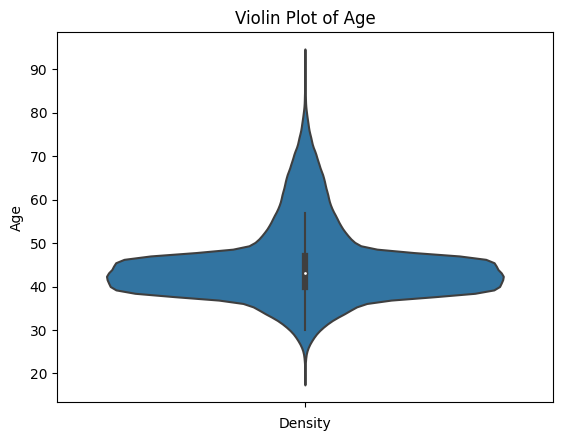

In [ ]:
sns.violinplot(data=customer, y='age')

# Set plot labels
plt.title('Violin Plot of Age')
plt.xlabel('Density')
plt.ylabel('Age')

# Display the plot
plt.show()


Above the distribution of the `age` column we just found. The majority of the clients are in the range 35-52, while the other age ranges are less populated.

#### **Clients per Region**

We could also investigate the areas where customers are more present.

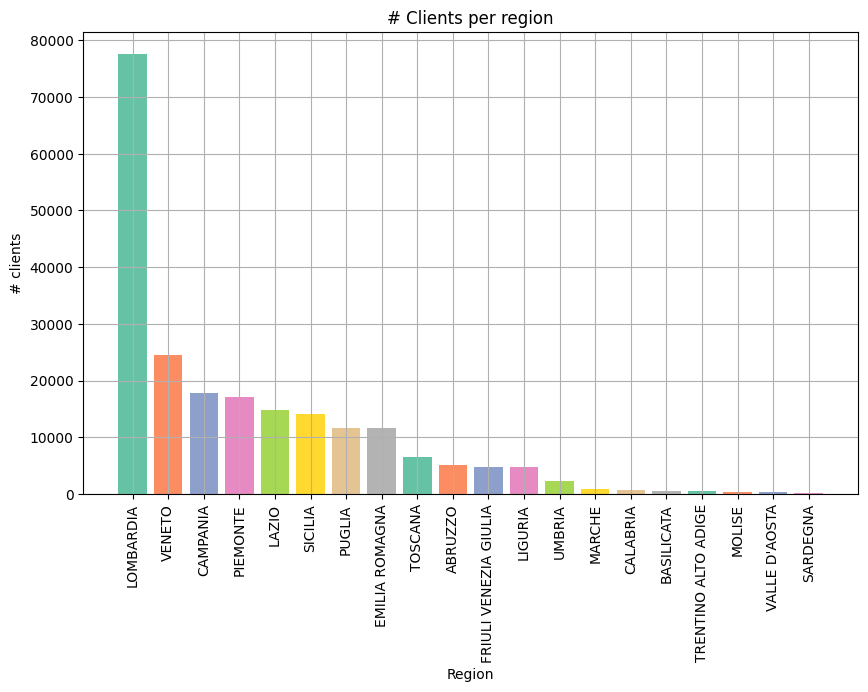

In [ ]:
customer_address = customer.merge(addresses, on='address_id', how='inner')
customer_count = customer_address['region'].value_counts()

# Sort regions by number of customers decreasingly
customer_count = customer_count.sort_values(ascending=False)

# Plot
plt.figure(figsize=(10, 6))
plt.bar(customer_count.index, customer_count.values, color=sns.color_palette('Set2'))
plt.grid()
plt.xlabel('Region')
plt.ylabel('# clients')
plt.title('# Clients per region')
plt.xticks(rotation=90)
plt.show()

We can see that more than the half of customer are from Lombardia.

## **Product focus**

#### **Unique products**

In [ ]:
len(products['product_id'].unique())

88538

In total, we offer our clients a large variety of items. In total, we provide **88.538 different products**.

#### **Top 10 best-selling products**

In [ ]:
df3 = orders.groupby(by='product_id').count()['order_id'].sort_values(ascending=False)

In [ ]:
df3.index = [str(x) for x in df3.index]

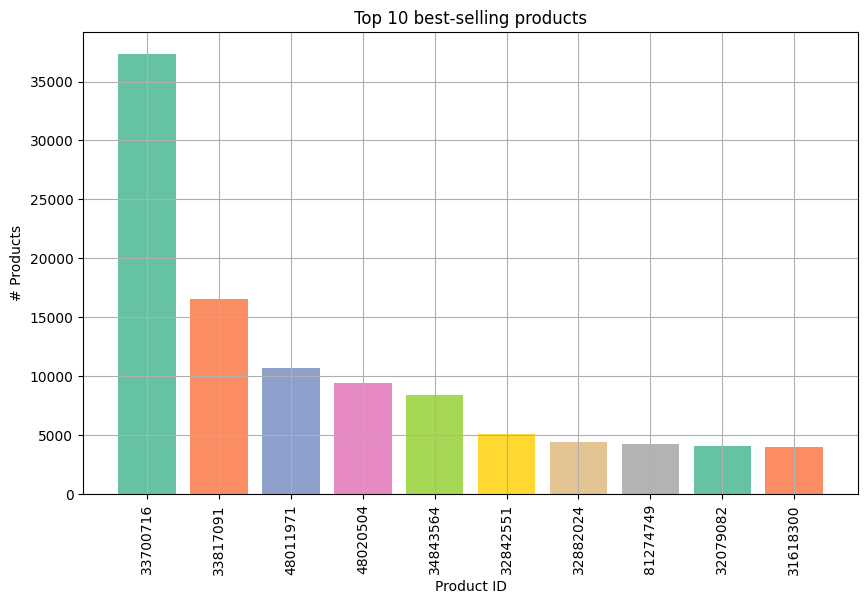

In [ ]:
plt.figure(figsize=(10, 6))
plt.bar(df3.head(10).index, df3.head(10).values, color=sns.color_palette('Set2'))
plt.grid()
plt.xlabel('Product ID')
plt.ylabel('# Products')
plt.title('Top 10 best-selling products')
plt.xticks(rotation=90)
plt.show()

These are the products that customers seems to enjoy more. Over the considered horizon, the product with id `33700716` was bougth more than 35.000 times!

#### **Products' categories**

Products are categorized in different classes. We can inspect them to catch which are the items' category that sells more easily.

In [ ]:
len(orders['order_id'].unique())

371804

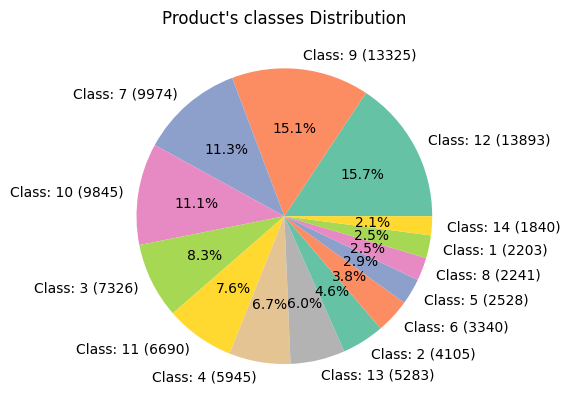

In [ ]:
class_counts = products['product_class'].value_counts()
#plt.pie(gender_counts, labels=gender_counts.index, autopct='%1.1f%%',colors=['pink','blue'])
plt.pie(class_counts, labels=[f'Class: {label} ({count})' for label, count in zip(class_counts.index, class_counts)],
        colors=sns.color_palette('Set2'), autopct='%1.1f%%')
plt.title("Product's classes Distribution")
plt.show()
plt.show()

## **Focus orders**

#### **Total number of orders**

In [ ]:
len(orders['product_id'].unique())

2000

In the given period of time, clients have placed 2.000 orders.

#### **Orders trend**

In [ ]:
df1 = orders.groupby(by='date_month').count()['order_id']

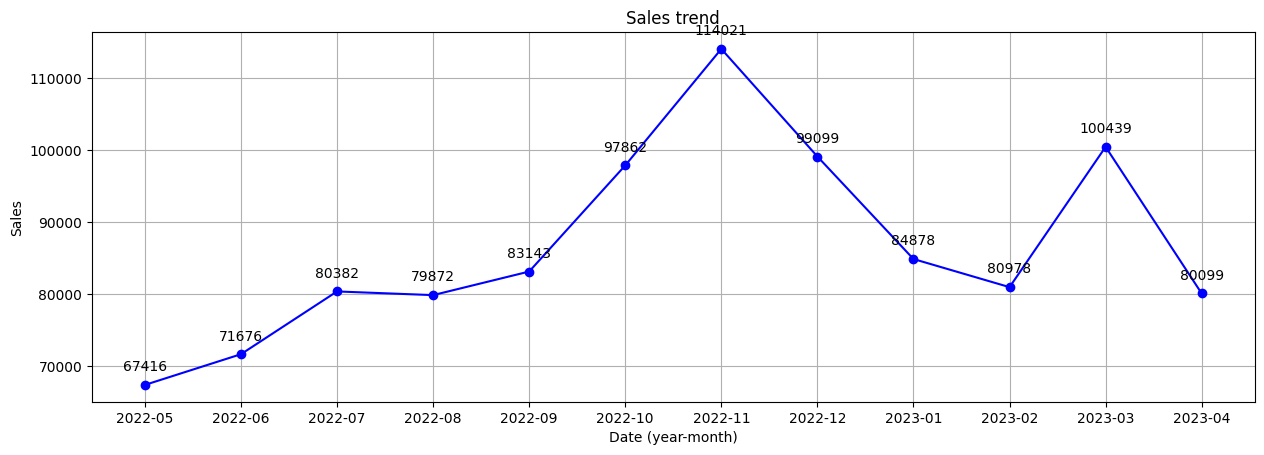

In [ ]:
plt.figure().set_figwidth(15)
plt.plot(df1, marker = 'o', color = 'blue')
plt.grid()
plt.title("Sales trend")
plt.xlabel("Date (year-month)")
plt.ylabel("Sales")
for x,y in zip(df1.index, df1):
    #label = "{:.2f}".format(y)
    plt.annotate(y, # this is the text
                 (x,y), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or cent
plt.show()

The plot displays the trend from the orders. Also in this case, we have a correspondence to the peak obseverd in the last plots in November 2022.

#### **Clients' expenditure**

In [ ]:
orders.head(3)

,order_id,customer_id,store_id,product_id,direction,gross_price,price_reduction,purchase_datetime,date_month
0,8fe4346b53d0c781b275a614175804de,23,49,35551922,1,125.40,0.0,2022-10-04T182851,2022-10
1,8fe4346b53d0c781b275a614175804de,23,49,30344384,1,8.30,0.0,2022-10-04T182851,2022-10
2,8fe4346b53d0c781b275a614175804de,23,49,33794292,1,1.99,0.0,2022-10-04T182851,2022-10


In [ ]:
round(sum(orders['gross_price'] - orders['price_reduction']),2)

25476999.12

On the period we are analysing, clients spent a total of **25.476.999,12 euros**!

In [ ]:
mean_exp = orders.groupby(by='customer_id')['gross_price'].mean()

In [ ]:
round(mean_exp.mean(),2)

26.25

While the mean expenditure per client was **26.25 euros** (gross expenditure).

In [ ]:
mean_exp_month = round(orders.groupby(by='date_month')['gross_price'].mean(),2)

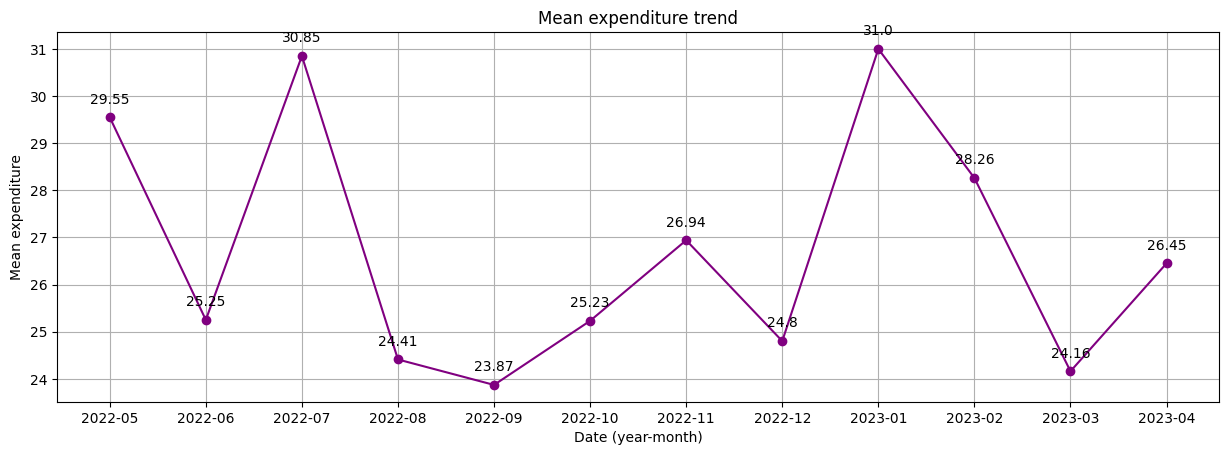

In [ ]:
plt.figure().set_figwidth(15)
plt.plot(mean_exp_month, marker = 'o', color = 'purple')
plt.grid()
plt.title("Mean expenditure trend")
plt.xlabel("Date (year-month)")
plt.ylabel("Mean expenditure")
for x,y in zip(mean_exp_month.index, mean_exp_month):
    #label = "{:.2f}".format(y)
    plt.annotate(y, # this is the text
                 (x,y), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or cent
plt.show()

Here we can see the mean expenditure per client. As we can see, the ternd is less homogeneous than the previous plots.

## **Focus reviews**

In [ ]:
len(labelled_reviews['labelled_reviews_index'].unique())

462744

We have a large number of reviews at our disposal, more than 462.000 reviews!

Here we plot the the *sentiment* related to the reviews left from the clients on our products.

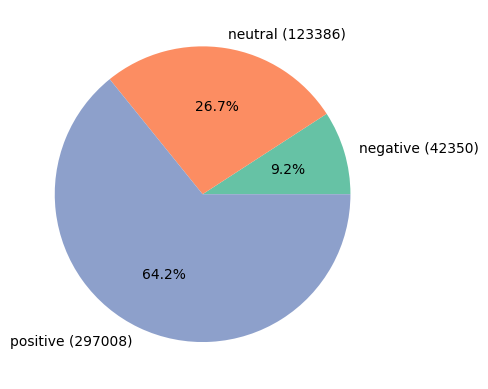

In [ ]:
count = labelled_reviews.groupby(by='sentiment_label').count()['labelled_reviews_index']
plt.pie(count.values, labels=[f'{label} ({count})' for label, count in zip(count.index, count)], autopct='%1.1f%%', colors=sns.color_palette('Set2'))
plt.show()

The majority of the reviws was positive or neutral, but we still observe a 10% of negative reviews. We could implement a strategy to satify our customer on the negative aspects of our products/services.

# **4. RFM**

*RFM* stands for **"recency, frequency, and monetary value"**. The idea is to segment customers based on when their last purchase was, how often they've purchased in the past, and how much they've spent overall.\
it allows marketers to **target specific clusters of customers** with communications that are much more relevant for their particular behavior – and thus generate much higher rates of response, plus increased loyalty and customer lifetime value.


### **1. Active Customers**
Definition of *active customer*: we define active customer every person that has purchased at least once during the 2023.

In [ ]:
#orders = pd.read_csv('tbl_orders.csv')
orders['date'] = pd.to_datetime(orders['purchase_datetime'], format='%Y-%m-%dT%H%M%S')
customer_ids_2023 = orders.loc[orders['date'].dt.year >= 2023 , 'customer_id'].unique()
active_orders = orders[orders['customer_id'].isin(customer_ids_2023)]
active_orders

,order_id,customer_id,store_id,product_id,direction,gross_price,price_reduction,purchase_datetime,date_month,date
0,8fe4346b53d0c781b275a614175804de,23,49,35551922,1,125.40,0.0,2022-10-04T182851,2022-10,2022-10-04 18:28:51
1,8fe4346b53d0c781b275a614175804de,23,49,30344384,1,8.30,0.0,2022-10-04T182851,2022-10,2022-10-04 18:28:51
2,8fe4346b53d0c781b275a614175804de,23,49,33794292,1,1.99,0.0,2022-10-04T182851,2022-10,2022-10-04 18:28:51
3,8fe4346b53d0c781b275a614175804de,23,49,33795776,1,5.10,0.0,2022-10-04T182851,2022-10,2022-10-04 18:28:51
4,8fe4346b53d0c781b275a614175804de,23,49,36235381,1,76.05,0.0,2022-10-04T182851,2022-10,2022-10-04 18:28:51
...,...,...,...,...,...,...,...,...,...,...
1039860,697c0078b69d9f8c119d8dd9a7952019,934581,29,35508942,1,33.60,0.0,2023-04-30T193553,2023-04,2023-04-30 19:35:53
1039861,86c9c4fdb8829e2ab90a86a357763419,934620,44,36237691,1,11.99,0.0,2023-04-30T191955,2023-04,2023-04-30 19:19:55
1039862,86c9c4fdb8829e2ab90a86a357763419,934620,44,81259479,1,9.99,0.0,2023-04-30T191955,2023-04,2023-04-30 19:19:55
1039863,86f8ca9e4008249e5e0acc5ff23e2284,934660,46,34067775,1,1.90,0.0,2023-04-30T193217,2023-04,2023-04-30 19:32:17


In [ ]:
active_orders[active_orders['gross_price']<0]

,order_id,customer_id,store_id,product_id,direction,gross_price,price_reduction,purchase_datetime,date_month,date
12,7927c5116d8aae47d86b75f67ac94a6f,23,49,33794292,-1,-1.99,0.0,2022-11-17T104929,2022-11,2022-11-17 10:49:29
13,7927c5116d8aae47d86b75f67ac94a6f,23,49,33795776,-1,-5.10,0.0,2022-11-17T104929,2022-11,2022-11-17 10:49:29
80,f74d58077490151356324b25f6f29052,48,49,33933655,-1,-43.92,0.0,2022-12-29T175621,2022-12,2022-12-29 17:56:21
83,ceb935c410873ca3213826fa0b393976,48,49,31047464,-1,-3.92,0.0,2022-12-29T191038,2022-12,2022-12-29 19:10:38
84,ceb935c410873ca3213826fa0b393976,48,49,33883955,-1,-113.00,0.0,2022-12-29T191038,2022-12,2022-12-29 19:10:38
...,...,...,...,...,...,...,...,...,...,...
1039581,6e21ab52559a47b71fd8670608b754d9,926607,39,81269181,-1,-11.52,0.0,2023-04-27T101247,2023-04,2023-04-27 10:12:47
1039582,148ecd18f8c783fafd5898f794ea812b,926607,39,81269181,-1,-23.04,0.0,2023-04-27T101309,2023-04,2023-04-27 10:13:09
1039626,c8b4e94fdfb6acfa76b5375ca176f8d7,927548,39,32842642,-1,-2.40,0.0,2023-04-27T115414,2023-04,2023-04-27 11:54:14
1039627,c8b4e94fdfb6acfa76b5375ca176f8d7,927548,39,32842600,-1,-21.60,0.0,2023-04-27T115414,2023-04,2023-04-27 11:54:14


In [ ]:
active_orders = active_orders[active_orders['gross_price'] >= 0]
active_orders

,order_id,customer_id,store_id,product_id,direction,gross_price,price_reduction,purchase_datetime,date_month,date
0,8fe4346b53d0c781b275a614175804de,23,49,35551922,1,125.40,0.0,2022-10-04T182851,2022-10,2022-10-04 18:28:51
1,8fe4346b53d0c781b275a614175804de,23,49,30344384,1,8.30,0.0,2022-10-04T182851,2022-10,2022-10-04 18:28:51
2,8fe4346b53d0c781b275a614175804de,23,49,33794292,1,1.99,0.0,2022-10-04T182851,2022-10,2022-10-04 18:28:51
3,8fe4346b53d0c781b275a614175804de,23,49,33795776,1,5.10,0.0,2022-10-04T182851,2022-10,2022-10-04 18:28:51
4,8fe4346b53d0c781b275a614175804de,23,49,36235381,1,76.05,0.0,2022-10-04T182851,2022-10,2022-10-04 18:28:51
...,...,...,...,...,...,...,...,...,...,...
1039860,697c0078b69d9f8c119d8dd9a7952019,934581,29,35508942,1,33.60,0.0,2023-04-30T193553,2023-04,2023-04-30 19:35:53
1039861,86c9c4fdb8829e2ab90a86a357763419,934620,44,36237691,1,11.99,0.0,2023-04-30T191955,2023-04,2023-04-30 19:19:55
1039862,86c9c4fdb8829e2ab90a86a357763419,934620,44,81259479,1,9.99,0.0,2023-04-30T191955,2023-04,2023-04-30 19:19:55
1039863,86f8ca9e4008249e5e0acc5ff23e2284,934660,46,34067775,1,1.90,0.0,2023-04-30T193217,2023-04,2023-04-30 19:32:17


#### **Recency Frequency Monetary Analysis**


---


RFM analysis is a data-driven marketing technique used to segment and analyze customers based on their recency, frequency, and monetary value of their transactions. It is a valuable tool for understanding customer behavior, identifying high-value customers, and tailoring marketing strategies accordingly.

The acronym "RFM" stands for the following:

* Recency (R): This factor measures the time elapsed since a customer's last purchase or interaction with a business. It indicates how recently a customer has engaged with the company, with more recent interactions often being more valuable.

* Frequency (F): Frequency represents the number of times a customer has made purchases or interacted with the business over a specific period. Customers who make frequent purchases are generally more engaged and potentially more loyal.

* Monetary Value (M): This factor quantifies the total amount of money a customer has spent on purchases or transactions with the business. It helps identify customers who are consistently making high-value purchases.

#### **2. Recency**
In order to gain valuable insights into customer behavior, it is crucial for businesses to understand the recency of customer purchases. This code performs a recency analysis by calculating the time elapsed since the most recent purchase for each customer.

The code begins by grouping the customer purchase data by customer ID. It then identifies the maximum purchase date for each customer, representing their most recent transaction. This information is stored in a new dataframe called "df_recency," which includes the customer ID and the corresponding purchase date.

Next, the code determines the overall most recent purchase date across all customers and stores it in the variable "recent_date." Using this information, the code calculates the recency value for each customer. By subtracting their individual purchase date from the recent date, the code calculates the number of days since their last purchase. The resulting recency values are added as a new column, labeled "Recency," in the "df_recency" dataframe.

In [ ]:
df_recency = active_orders.groupby(by='customer_id',
                        as_index=False)['purchase_datetime'].max()
df_recency.columns = ['customer_id', 'purchase_datetime']
recent_date = df_recency['purchase_datetime'].max()
df_recency['Recency'] = df_recency['purchase_datetime'].apply(lambda x: (datetime.strptime(recent_date, "%Y-%m-%dT%H%M%S") - datetime.strptime(x, "%Y-%m-%dT%H%M%S")).days)
df_recency.head()

,customer_id,purchase_datetime,Recency
0,23,2023-02-20T115151,69
1,32,2023-04-02T151158,28
2,48,2023-04-30T193536,0
3,50,2023-02-19T165632,70
4,76,2023-03-08T192327,53


In [ ]:
df_recency

,customer_id,purchase_datetime,Recency
0,23,2023-02-20T115151,69
1,32,2023-04-02T151158,28
2,48,2023-04-30T193536,0
3,50,2023-02-19T165632,70
4,76,2023-03-08T192327,53
...,...,...,...
54847,934484,2023-04-30T190211,0
54848,934581,2023-04-30T193553,0
54849,934620,2023-04-30T191955,0
54850,934660,2023-04-30T193217,0


In [ ]:
df_recency['Recency'].describe()

count    54852.000000
mean        49.513910
std         34.588834
min          0.000000
25%         22.000000
50%         45.000000
75%         76.000000
max        239.000000
Name: Recency, dtype: float64

These **statistics** provide valuable insights into the recency of customer purchases:

**Count**: The count of 54,852 indicates the total number of customers included in the analysis. This represents the sample size and shows the number of customers for whom recency values were calculated.

**Mean**: The mean recency value of 49.5 suggests that, on average, customers made a purchase or interacted with the business approximately 49 to 50 days ago. This provides a general understanding of the typical recency timeframe for customer engagement.

**Standard Deviation (std)**: The standard deviation of 34.5 indicates the dispersion or variability of the recency values around the mean. A higher standard deviation suggests a wider spread of recency values, indicating a diverse range of customer engagement patterns.

**Minimum (min)**: The minimum recency value of 0 suggests that some customers have made a purchase very recently, indicating a group of highly engaged or active customers.

**25th Percentile (25%)**: The 25th percentile value of 22 indicates that 25% of customers made a purchase within the past 22 days. This can be seen as a threshold for recent engagement, providing insight into the lower end of the recency values.

**Median (50%)**: The median recency value of 45 represents the midpoint of the recency distribution. This means that 50% of customers made a purchase within the past 45 days, while the other 50% made a purchase longer ago.

**75th Percentile (75%)**: The 75th percentile value of 76 indicates that 75% of customers made a purchase within the past 76 days. This can be seen as a threshold for less recent engagement, providing insight into the higher end of the recency values.

**Maximum (max)**: The maximum recency value of 239 suggests that some customers have not made a purchase or engaged with the business for up to 239 days. This may indicate a group of inactive or dormant customers who require targeted re-engagement strategies.

#### **3. Frequency**

To effectively understand customer behavior and engagement, businesses need to analyze the frequency of customer purchases. This code performs a frequency analysis by calculating the number of purchases made by each customer.

The code starts by eliminating any duplicate orders from the dataset. It then groups the remaining unique orders by customer ID. By counting the number of unique purchase dates for each customer, the code determines the frequency of their purchases.

The resulting dataframe, named "frequency_df," contains two columns: customer_id and Frequency. The customer_id column represents the unique identifier for each customer, while the Frequency column displays the count of their purchases.

This code provides businesses with valuable information about customer purchasing habits. By examining the frequency of purchases, businesses can identify their most loyal and engaged customers, as well as those who may require targeted marketing efforts to increase their frequency of purchases.

In [ ]:
frequency_df = active_orders.drop_duplicates().groupby(
    by=['customer_id'], as_index=False)['purchase_datetime'].count()
frequency_df.columns = ['customer_id', 'Frequency']
frequency_df.head()

,customer_id,Frequency
0,23,36
1,32,11
2,48,52
3,50,4
4,76,3


In [ ]:
frequency_df['Frequency'].describe()

count    54852.000000
mean        10.662054
std         12.877826
min          1.000000
25%          3.000000
50%          6.000000
75%         13.000000
max        254.000000
Name: Frequency, dtype: float64

These **statistics** provide valuable insights into the frequency of customer purchases:

**Count**: The count of 104,134 indicates the total number of customers included in the analysis. This represents the sample size and shows the number of customers for whom frequency values were calculated.

**Mean**: The mean frequency value of 8.805962 suggests that, on average, customers made approximately 8 to 9 purchases during the analyzed period. This provides a general understanding of the typical number of purchases per customer.

**Standard Deviation (std)**: The standard deviation of 11.901612 indicates the dispersion or variability of the frequency values around the mean. A higher standard deviation suggests a wider spread of frequency values, reflecting diverse purchasing behaviors among customers.

**Minimum (min)**: The minimum frequency value of 1.000000 signifies that some customers made only a single purchase during the analyzed period. These customers may represent occasional buyers or those who made a single significant purchase.

**25th Percentile (25%)**: The 25th percentile value of 2.000000 indicates that 25% of customers made two or fewer purchases during the analyzed period. This can serve as a threshold for infrequent or low-frequency customers.

**Median (50%)**: The median frequency value of 5.000000 represents the midpoint of the frequency distribution. This means that 50% of customers made five or fewer purchases, while the other 50% made more frequent purchases.

**75th Percentile (75%)**: The 75th percentile value of 11.000000 indicates that 75% of customers made 11 or fewer purchases during the analyzed period. This can be seen as a threshold for higher-frequency customers.

**Maximum (max)**: The maximum frequency value of 449.000000 suggests the presence of a few customers with exceptionally high purchase frequencies. These customers may represent loyal or highly engaged individuals who contribute significantly to the business's revenue.

We want to check if `price_reduction` is in percentage or it's a value:

In [ ]:
filtered_df = active_orders[active_orders['price_reduction'] > 0]
filtered_df.head()

,order_id,customer_id,store_id,product_id,direction,gross_price,price_reduction,purchase_datetime,date_month,date
5,c2ae3673970490406925dcd3f8a4d486,23,49,35002296,1,1.70,0.17,2022-10-31T130742,2022-10,2022-10-31 13:07:42
6,c2ae3673970490406925dcd3f8a4d486,23,49,32157580,1,1.90,0.19,2022-10-31T130742,2022-10,2022-10-31 13:07:42
7,c2ae3673970490406925dcd3f8a4d486,23,49,35930902,1,0.70,0.07,2022-10-31T130742,2022-10,2022-10-31 13:07:42
8,c2ae3673970490406925dcd3f8a4d486,23,49,81268736,1,9.90,0.99,2022-10-31T130742,2022-10,2022-10-31 13:07:42
9,c2ae3673970490406925dcd3f8a4d486,23,49,35930965,1,2.25,0.23,2022-10-31T130742,2022-10,2022-10-31 13:07:42


Noted that the `price_reduction` is not a relative measure but an effective value, we want to calcualte the final price that the customer paid.

### **4. Monetary**
In order to gain insights into customer spending and profitability, businesses need to understand the monetary value of customer purchases. This code performs a calculation to determine the total monetary value of purchases made by each customer.

To begin, the code adjusts the prices of orders by subtracting any price reductions from the gross price. This adjustment ensures that we consider the actual amount spent by customers on their purchases, providing a more accurate representation of their monetary value.

Next, the code groups the orders by customer ID and calculates the sum of the adjusted prices for each customer. This aggregation allows us to obtain the total monetary value of purchases made by each customer.

The resulting dataframe, named "monetary_df," contains two columns: customer_id and Monetary. The customer_id column represents the unique identifier for each customer, while the Monetary column displays the calculated total monetary value of their purchases.

In [ ]:
active_orders['price'] = active_orders['gross_price']-active_orders['price_reduction']
monetary_df = active_orders.groupby(by='customer_id', as_index=False)['price'].sum()
monetary_df.columns = ['customer_id', 'Monetary']
monetary_df.head()

<ipython-input-56-13fa2f023c6f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  active_orders['price'] = active_orders['gross_price']-active_orders['price_reduction']


,customer_id,Monetary
0,23,481.64
1,32,58.85
2,48,1465.17
3,50,26.04
4,76,14.60


In [ ]:
monetary_df['Monetary'].describe()

count     54852.000000
mean        318.317244
std        2661.409460
min           0.000000
25%          23.387500
50%          74.080000
75%         218.280000
max      329814.810000
Name: Monetary, dtype: float64

These **statistics** provide valuable insights into the monetary value of customer purchases:

**Count**: The count of 104,134 indicates the total number of customers included in the analysis. This represents the sample size and shows the number of customers for whom monetary values were calculated.

**Mean**: The mean monetary value of 244.655916 suggests that, on average, customers spent approximately $245 on their purchases. This provides a general understanding of the typical spending level per customer.

**Standard Deviation (std)**: The standard deviation of 2214.437880 indicates the dispersion or variability of the monetary values around the mean. A higher standard deviation suggests a wider spread of monetary values, reflecting diverse spending behaviors among customers.

**Minimum (min)**: The minimum monetary value of -24209.660000 indicates the presence of customers who had negative values, possibly due to returns, cancellations, or errors in the data. These negative values should be investigated further to ensure data accuracy.

**25th Percentile (25%)**: The 25th percentile value of 16.360000 suggests that 25% of customers had a monetary value of $16 or lower. This can serve as a threshold for lower-spending customers.

**Median (50%)**: The median monetary value of 54.895000 represents the midpoint of the monetary value distribution. This means that 50% of customers spent $54.90 or less, while the other 50% spent more.

**75th Percentile (75%)**: The 75th percentile value of 172.145000 indicates that 75% of customers had a monetary value of $172 or lower. This can be seen as a threshold for higher-spending customers.

**Maximum (max)**: The maximum monetary value of 329,814.810000 suggests the presence of a few customers who made substantial purchases. These high-value customers significantly contributed to the overall revenue.

This is the **table with Recency, Frequency and Monetary for each customer**:

In [ ]:
rf_df = df_recency.merge(frequency_df, on='customer_id')
rfm_df = rf_df.merge(monetary_df, on='customer_id').drop(
    columns='purchase_datetime')
rfm_df

,customer_id,Recency,Frequency,Monetary
0,23,69,36,481.64
1,32,28,11,58.85
2,48,0,52,1465.17
3,50,70,4,26.04
4,76,53,3,14.60
...,...,...,...,...
54847,934484,0,5,35.01
54848,934581,0,1,33.60
54849,934620,0,2,21.98
54850,934660,0,1,1.90


We can now easly transform the raw RFM (Recency, Frequency, Monetary) values into a normalized and segmented format for effective customer analysis.

First, the code assigns ranks to the customers based on their Recency, Frequency, and Monetary values. For Recency and Frequency higher ranks indicate better performance, while in case of Monetary the lowest rank corresponds to the highest perdormance. The 'R_rank', 'F_rank', and 'M_rank' columns are added to the 'rfm_df' dataframe to represent the respective ranks for each customer.

Next, the code normalizes the ranks by scaling them to a 0-100 range using the maximum rank value. This step ensures consistency in comparison across different metrics. Normalized ranks are stored in the 'R_rank_norm', 'F_rank_norm', and 'M_rank_norm' columns.

The code then segments customers based on their normalized ranks. For the Recency and Frequency metrics, the customers are divided into three segments, labeled as 0, 1, and 2, based on percentile cutoffs. For the Monetary metric, the segments are labeled as 2, 1, and 0.

Finally, the code drops the intermediate rank columns ('R_rank', 'F_rank', 'M_rank') as they are no longer needed.

By applying this code, businesses can segment their customer base into different groups based on their RFM scores. These segments enable businesses to better understand customer behavior, tailor marketing strategies, and prioritize resource allocation. The segmentation provides actionable insights into customer engagement, loyalty, and revenue generation potential.

In [ ]:
rfm_df['R_rank'] = rfm_df['Recency'].rank(ascending=False)
rfm_df['F_rank'] = rfm_df['Frequency'].rank(ascending=True)
rfm_df['M_rank'] = rfm_df['Monetary'].rank(ascending=True)

# normalizing the rank of the customers
rfm_df['R_rank_norm'] = (rfm_df['R_rank']/rfm_df['R_rank'].max())*100
rfm_df["RScore"] = pd.cut(rfm_df["R_rank_norm"],
                                       bins=[0,
                                             np.percentile(rfm_df["R_rank_norm"], 33.3),
                                             np.percentile(rfm_df["R_rank_norm"], 66.6),
                                             rfm_df["R_rank_norm"].max()],
                                       labels=[2, 1, 0]).astype("int")
rfm_df['F_rank_norm'] = (rfm_df['F_rank']/rfm_df['F_rank'].max())*100
rfm_df["FScore"] = pd.cut(rfm_df["F_rank_norm"],
                                       bins=[0,
                                             np.percentile(rfm_df["F_rank_norm"], 33.3),
                                             np.percentile(rfm_df["F_rank_norm"], 66.6),
                                             rfm_df["F_rank_norm"].max()],
                                       labels=[0, 1, 2]).astype("int")
rfm_df['M_rank_norm'] = (rfm_df['F_rank']/rfm_df['M_rank'].max())*100
rfm_df["MScore"] = pd.cut(rfm_df["M_rank_norm"],
                                       bins=[0,
                                             np.percentile(rfm_df["M_rank_norm"], 33.3),
                                             np.percentile(rfm_df["M_rank_norm"], 66.6),
                                             rfm_df["M_rank_norm"].max()],
                                       labels=[0, 1, 2]).astype("int")

rfm_df.drop(columns=['R_rank', 'F_rank', 'M_rank'], inplace=True)

rfm_df.head()

,customer_id,Recency,Frequency,Monetary,R_rank_norm,RScore,F_rank_norm,FScore,M_rank_norm,MScore
0,23,69,36,481.64,30.332508,2,95.451396,2,95.451396,2
1,32,28,11,58.85,67.247076,1,68.635601,2,68.635601,2
2,48,0,52,1465.17,100.000000,0,98.304529,2,98.304529,2
3,50,70,4,26.04,29.787684,2,34.236673,0,34.236673,0
4,76,53,3,14.60,42.409741,1,25.874170,0,25.874170,0


#### **5. RFM-Matrix**

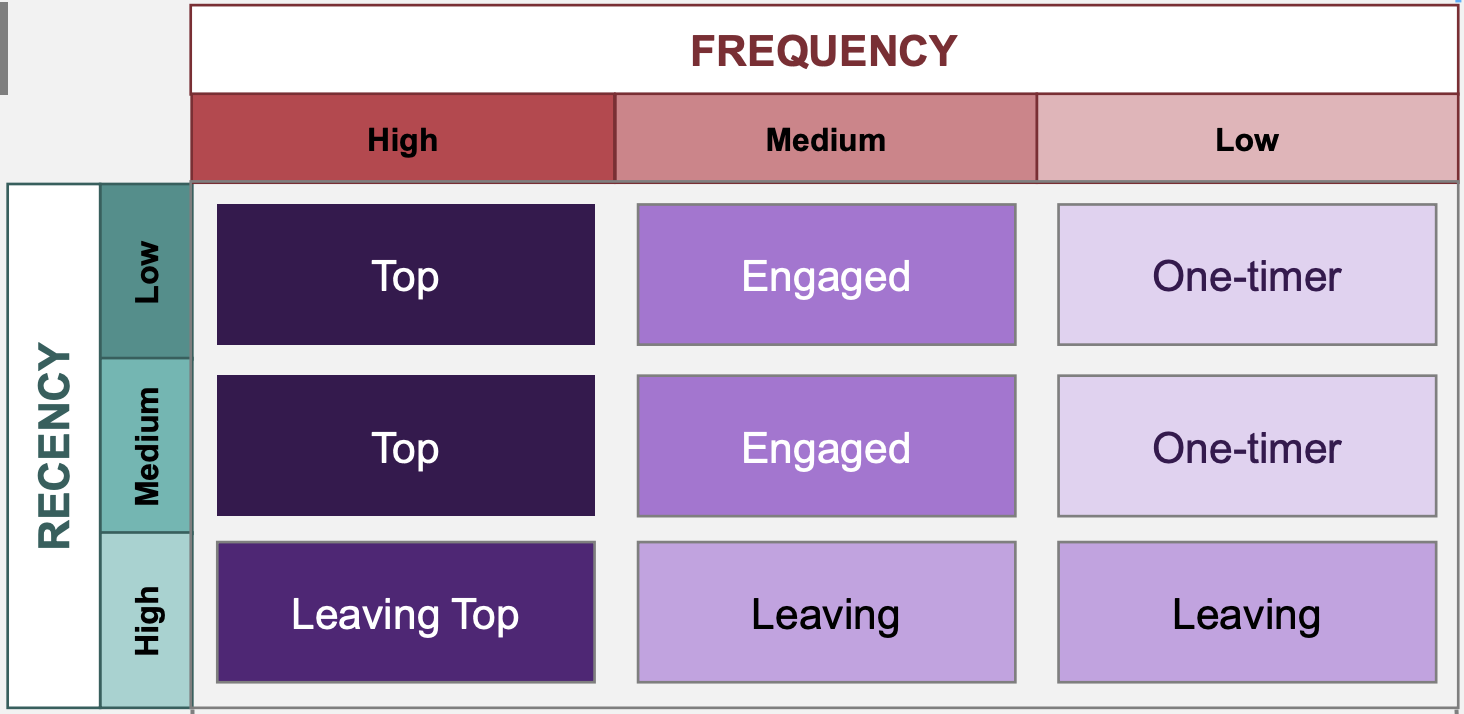


We now can build the **Recency-Frequency matrix**.


*   0: One-timer
*  1: Leaving
* 2: Engaged
* 3: Leaving Top
* 4: Top



In [ ]:
rf_matrix = {
    (0, 0): 0,
    (0, 1): 0,
    (0, 2): 1,
    (1, 0): 2,
    (1, 1): 2,
    (1, 2): 1,
    (2, 0): 4,
    (2, 1): 4,
    (2, 2): 3
}
rfm_df['rf'] = rfm_df.apply(lambda x: rf_matrix[(x['FScore'], x['RScore'])], axis=1)
rfm_df

,customer_id,Recency,Frequency,Monetary,R_rank_norm,RScore,F_rank_norm,FScore,M_rank_norm,MScore,rf
0,23,69,36,481.64,30.332508,2,95.451396,2,95.451396,2,3
1,32,28,11,58.85,67.247076,1,68.635601,2,68.635601,2,4
2,48,0,52,1465.17,100.000000,0,98.304529,2,98.304529,2,4
3,50,70,4,26.04,29.787684,2,34.236673,0,34.236673,0,1
4,76,53,3,14.60,42.409741,1,25.874170,0,25.874170,0,0
...,...,...,...,...,...,...,...,...,...,...,...
54847,934484,0,5,35.01,100.000000,0,41.508058,1,41.508058,1,2
54848,934581,0,1,33.60,100.000000,0,5.700795,0,5.700795,0,0
54849,934620,0,2,21.98,100.000000,0,16.412346,0,16.412346,0,0
54850,934660,0,1,1.90,100.000000,0,5.700795,0,5.700795,0,0


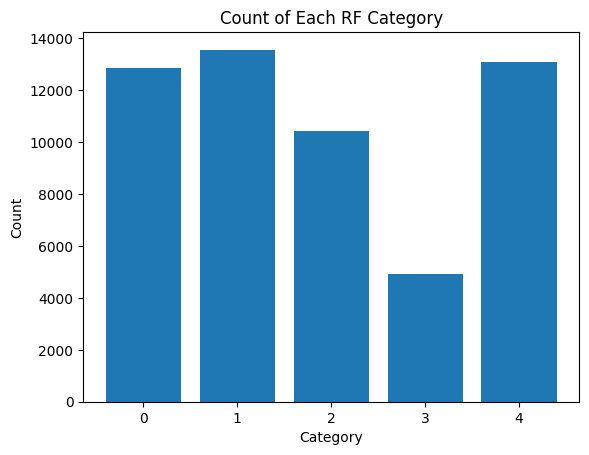

In [ ]:
rf_category_counts = rfm_df['rf'].value_counts()

# Create the bar chart
plt.bar(rf_category_counts.index, rf_category_counts.values)

# Add labels and title
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('Count of Each RF Category')

# Display the chart
plt.show()

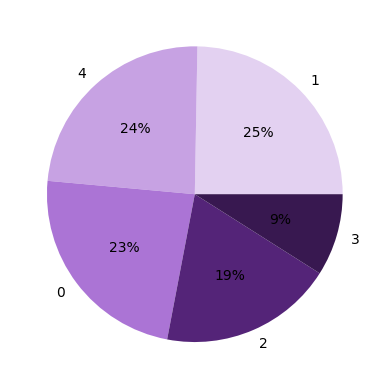

In [ ]:
plt.pie(rfm_df.rf.value_counts(),
        labels=rfm_df.rf.value_counts().index,
        autopct='%.0f%%',
        colors=["#e3d1f1","#c7a2e3","#ab74d5","#542478","#381850"])
plt.show()

### **6. RFM-Matrix**
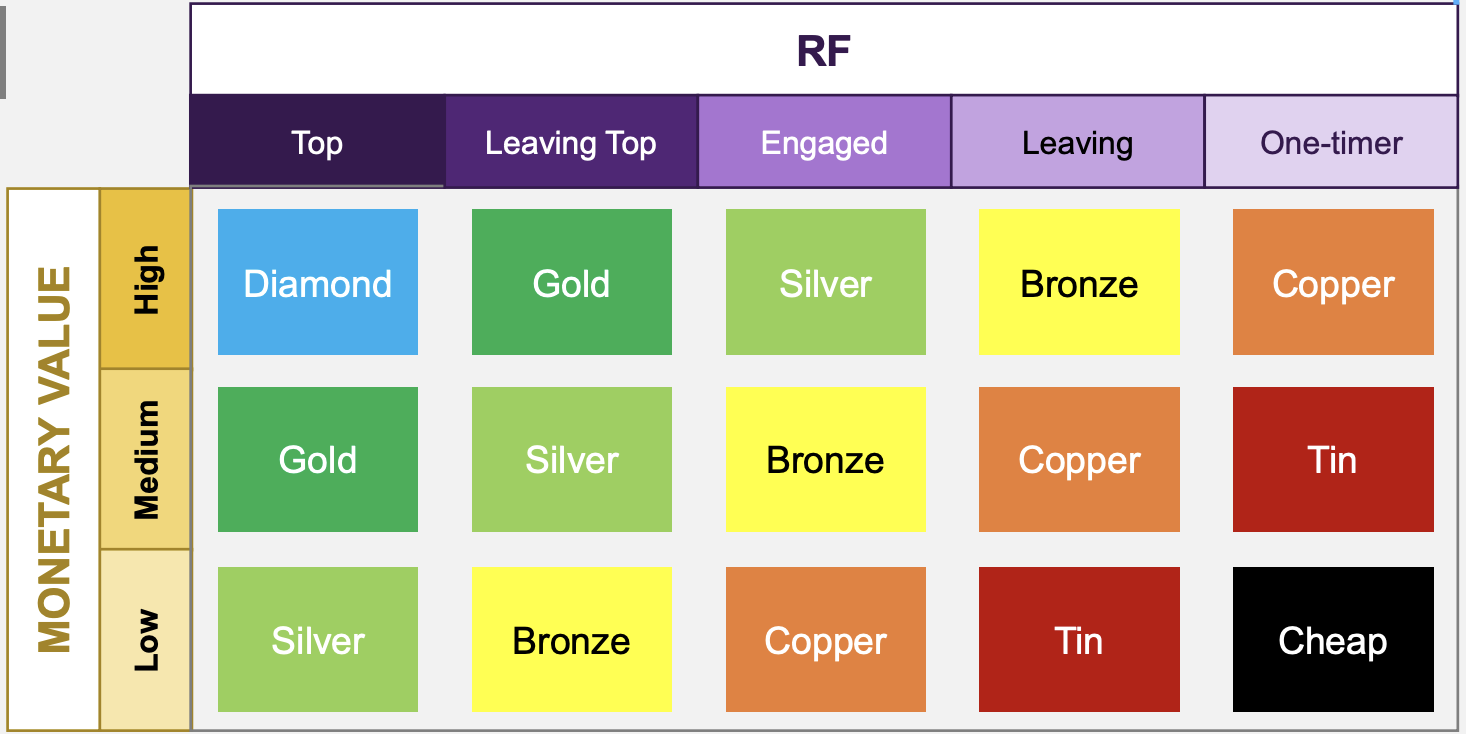

Having RF-matrix we can build the **RFM matrix**:


*   0: Cheap
* 1: Tin
* 2: Copper
* 3: Bronze
* 4: Silver
* 5: Gold
* 6: Diamond



In [ ]:
rfm_matrix = {
    (0, 0): 0,
    (0, 1): 1,
    (0, 2): 2,
    (0, 3): 3,
    (0, 4): 4,
    (1, 0): 1,
    (1, 1): 2,
    (1, 2): 3,
    (1, 3): 4,
    (1, 4): 5,
    (2, 0): 2,
    (2, 1): 3,
    (2, 2): 4,
    (2, 3): 5,
    (2, 4): 6,
}
rfm_df['MScore'] = rfm_df['MScore'].astype(int)
rfm_df['rf'] = rfm_df['rf'].astype(int)
rfm_df['rfm'] = rfm_df.apply(lambda x: rfm_matrix[(x['MScore'], x['rf'])], axis=1)
rfm_df['rfm'] = rfm_df['rfm'].astype(int)
rfm_df

,customer_id,Recency,Frequency,Monetary,R_rank_norm,RScore,F_rank_norm,FScore,M_rank_norm,MScore,rf,rfm
0,23,69,36,481.64,30.332508,2,95.451396,2,95.451396,2,3,5
1,32,28,11,58.85,67.247076,1,68.635601,2,68.635601,2,4,6
2,48,0,52,1465.17,100.000000,0,98.304529,2,98.304529,2,4,6
3,50,70,4,26.04,29.787684,2,34.236673,0,34.236673,0,1,1
4,76,53,3,14.60,42.409741,1,25.874170,0,25.874170,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
54847,934484,0,5,35.01,100.000000,0,41.508058,1,41.508058,1,2,3
54848,934581,0,1,33.60,100.000000,0,5.700795,0,5.700795,0,0,0
54849,934620,0,2,21.98,100.000000,0,16.412346,0,16.412346,0,0,0
54850,934660,0,1,1.90,100.000000,0,5.700795,0,5.700795,0,0,0


The output of the RFM analysis is the RFM matrix, which provides a comprehensive view of customer segmentation based on recency, frequency, and monetary value. The RFM matrix categorizes customers into distinct segments, allowing us to tailor our strategies to meet the specific needs and behaviors of each group. Each customer is assigned a combination of RFM scores that indicate their level of engagement and value to our supermarket. By analyzing the RFM matrix, we can identify segments such as high-value, loyal customers, new and promising customers, dormant customers requiring reactivation, and more. This segmentation enables us to develop targeted marketing campaigns, personalized offers, and customer retention initiatives that are designed to maximize customer satisfaction, loyalty, and overall business growth.

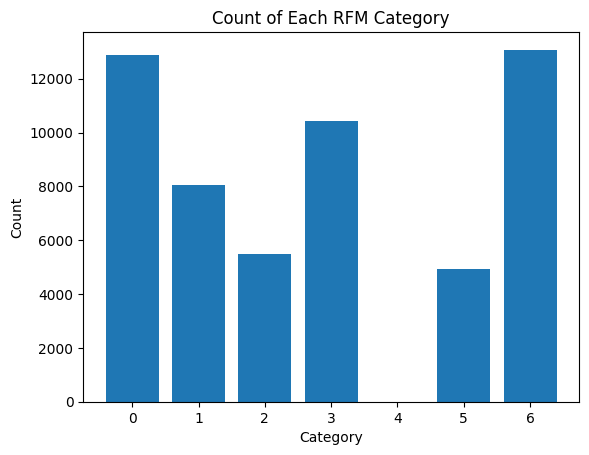

In [ ]:
# Count the occurrences of each category
category_counts = rfm_df['rfm'].value_counts()

# Create the bar chart
plt.bar(category_counts.index, category_counts.values)

# Add labels and title
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('Count of Each RFM Category')

# Display the chart
plt.show()

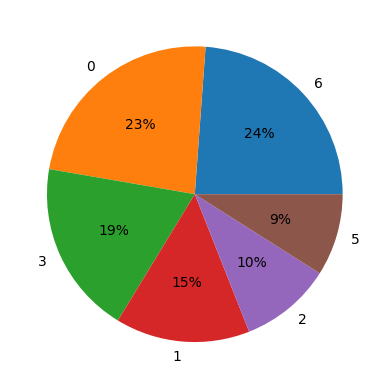

In [ ]:
plt.pie(rfm_df.rfm.value_counts(),
        labels=rfm_df.rfm.value_counts().index,
        autopct='%.0f%%')
plt.show()

We need to formulate effective business strategies specifically targeting our high-value customers, who are characterized by their significant monetary value, recent purchases, and high frequency of purchase. We are willing to allocate a substantial portion of our budget to maintain their engagement and boost conversions.

We have three proposed ideas:

Personalized Loyalty Programs: Develop a tiered loyalty program that offers exclusive benefits to high-value customers. This could include special discounts, early access to sales, personalized offers tailored to their preferences, and invitations to exclusive events.

Personalized Communication: Establish direct and personalized communication channels with our high-value customers. Utilize targeted emails or SMS messages to showcase special promotions, discounts, or new product launches that align with their preferences. It is essential to utilize their preferred communication channels to ensure maximum message reception and engagement.

Special Events and Workshops: Organize exclusive events, workshops, or cooking classes specifically tailored for our high-value customers. These events could feature tastings, demonstrations by renowned chefs, or educational sessions on nutrition and healthy cooking. By creating an exclusive community for these customers, they will feel a sense of belonging and importance, making it highly unlikely for them to desire to disengage from it.

Among the three ideas, we acknowledge that the third one may require a higher financial investment. However, it holds the potential for the highest level of engagement as it fosters the development of a dedicated community. This strategy aims to make our customers feel special and connected, leading them to be strongly motivated to remain a part of the community.

Improvement: One potential improvement of these strategies is the ability to gather valuable customer feedback and insights. By implementing personalized loyalty programs, personalized communication, and special events, you create opportunities to engage with high-value customers on a deeper level. This interaction allows you to gather feedback about their preferences, needs, and satisfaction levels. By actively listening to your customers, you can continuously improve your products, services, and overall customer experience, leading to better customer retention and loyalty.

Side Effect: One possible side effect of these strategies is the potential for increased expectations and demands from high-value customers. When customers are provided with personalized benefits, exclusive access, and special treatment, their expectations may rise accordingly. They may come to expect a consistently high level of service, customization, and perks. As a result, there could be added pressure to continually meet or exceed these elevated expectations, which may require ongoing investments and resources. However, by carefully managing customer expectations and maintaining open communication, you can mitigate potential negative side effects and ensure a positive customer experience

# **5. Churn prediction**

**Churn rate** (sometimes called attrition rate), in its broadest sense, is a measure of the number of individuals or items moving out of a collective group over a specific period.\
The purpose of the churn is to **predict which customers are most likely to abandon** and allow the company to intervene with appropriate retention initiatives.

#### **1. Active customers definition**
We have to define our **target variable** (`churn`), so we want to analyze people who have purchase at least two times (not occasionally) and consider the last time that they purchased.\
In this context, *active customers* are clients that made more than one purchase.

In [ ]:
# Convert the 'purchase_datetime' column to datetime type
orders['date'] = pd.to_datetime(orders['purchase_datetime'])

# Sort the orders by 'customer_id' and 'purchase_datetime'
orders = orders.sort_values(['customer_id', 'date'])

# Calculate the time difference between consecutive purchases for each customer
orders['repurchase_time'] = orders.groupby('customer_id')['date'].diff()
new_table=orders.loc[orders['repurchase_time'] >= pd.Timedelta(days=1), ['customer_id', 'repurchase_time','date']].copy()
print(new_table)

         customer_id  repurchase_time                date
5                 23 26 days 18:38:51 2022-10-31 13:07:42
12                23 16 days 21:41:47 2022-11-17 10:49:29
17                23 12 days 04:58:00 2022-11-29 16:26:28
19                23  6 days 19:59:53 2022-12-06 12:26:21
30                23 15 days 04:41:55 2022-12-21 17:08:16
...              ...              ...                 ...
1039658       928567  2 days 01:18:10 2023-04-29 12:28:33
1039672       928707  3 days 02:25:42 2023-04-30 14:10:28
1039684       928777  2 days 20:41:27 2023-04-30 10:02:16
1039727       929438  1 days 08:33:36 2023-04-30 20:26:19
1039758       929899  2 days 17:17:36 2023-04-30 12:09:56

[228784 rows x 3 columns]


In [ ]:
unique_rows = new_table.groupby('customer_id')['repurchase_time'].mean().reset_index()
print(unique_rows)

       customer_id            repurchase_time
0               23 23 days 02:47:20.166666666
1               30           41 days 12:24:44
2               32           15 days 00:11:48
3               48 28 days 21:28:44.444444444
4               50           32 days 01:07:13
...            ...                        ...
69665       928567            2 days 01:18:10
69666       928707            3 days 02:25:42
69667       928777            2 days 20:41:27
69668       929438            1 days 08:33:36
69669       929899            2 days 17:17:36

[69670 rows x 2 columns]


In [ ]:
unique_rows['repurchase_time']/= np.timedelta64(1, 'D')
unique_rows[unique_rows['customer_id']==23]

,customer_id,repurchase_time
0,23,23.116206


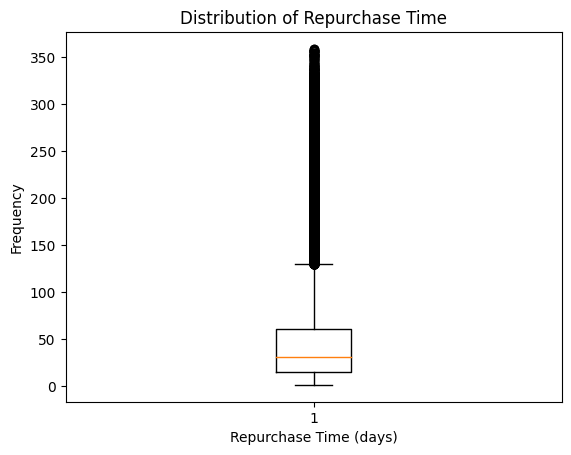

In [ ]:
plt.boxplot(unique_rows['repurchase_time'])

# Set plot labels and title
plt.xlabel('Repurchase Time (days)')
plt.ylabel('Frequency')
plt.title('Distribution of Repurchase Time')

# Display the plot
plt.show()

Here we remove outliers from our analysis. All the client that fall outdite the 75% percentile are not considered.

In [ ]:
unique_rows['repurchase_time'].quantile([0.25,0.5,0.75])

0.25    15.075666
0.50    31.012490
0.75    60.965719
Name: repurchase_time, dtype: float64

This is the `avg` of every repurchase for each customer.

In [ ]:
unique_rows['repurchase_time'].mean()

47.877580852586384

In [ ]:
print(unique_rows[unique_rows['customer_id'] == 23])

   customer_id  repurchase_time
0           23        23.116206


At this point, `unique_rows` contains all the clients that we consider active and we know how many days have passed from the first order and a repurchase. We will use their information to decided wheter they are churners or not.\
We set the `reference_date` (2023-01-01), the `lookback_period` and the `holdout_period`.\
If a customer **did not at least complete two purchases** in the interval [`lookback_period`, `holdout_period`], we consider him as **churner**.

In [ ]:
reference_date = pd.to_datetime('2023-01-01')
lookback_period = pd.DateOffset(days=30)
holdout_period = pd.DateOffset(days=47)

# Convert purchase_datetime column to pandas Timestamp
orders['purchase_datetime'] = pd.to_datetime(orders['purchase_datetime'], format='%Y-%m-%dT%H%M%S')

# Calculate the start and end dates for the churn period
start_date = reference_date - lookback_period

# Filter orders within the churn period
lookback_orders = orders[(orders['purchase_datetime'] >= start_date)& (orders['purchase_datetime'] <= reference_date)]
first_orders = lookback_orders.groupby('customer_id').first().reset_index()

# Create a mask to check if the condition is satisfied for each order in 'first_orders'
mask = first_orders.apply(lambda row: orders[
    (orders['customer_id'] == row['customer_id']) &
    (orders['purchase_datetime'] > row['purchase_datetime']) &
    (orders['purchase_datetime'] <= row['purchase_datetime'] + holdout_period)
].empty, axis=1)

# Apply the mask to filter 'first_orders'
churn_orders = first_orders[~mask]

print(churn_orders)

       customer_id                          order_id  store_id  product_id  \
0               23  813f7eae0fffc3cbf0860194efb04084        49    34663916   
1               48  d31667c850c1b3c744415190a9bd1aad        49    33933613   
5              292  c3b81e7b4b2d8593ff71199c6a18d09d        28    35573356   
6              331  18d7888737c2dfd50866fcbecdcb932c        43    35859005   
7              375  4d2230e25f3a70f3059f526f84e86f19        17    31618321   
...            ...                               ...       ...         ...   
20847       759229  a3cd5b2b8c5da96c5f622560fc81923b        27    36128176   
20848       759233  4e00d8322b5a74cb5c32ed5382ce6929         6    34088733   
20851       759406  d905a4007415ab3589240f67d00503e9        24    32863712   
20852       759431  3fd4f1b787f80400880fe816c1ac9f85        24    36593872   
20854       759483  a4be64e284fd50d6a67fdf6af07f8e1b        47    81259496   

       direction  gross_price  price_reduction   purchase_datet

In [ ]:
unique_rows['churn'] = unique_rows['customer_id'].isin(churn_orders['customer_id'])

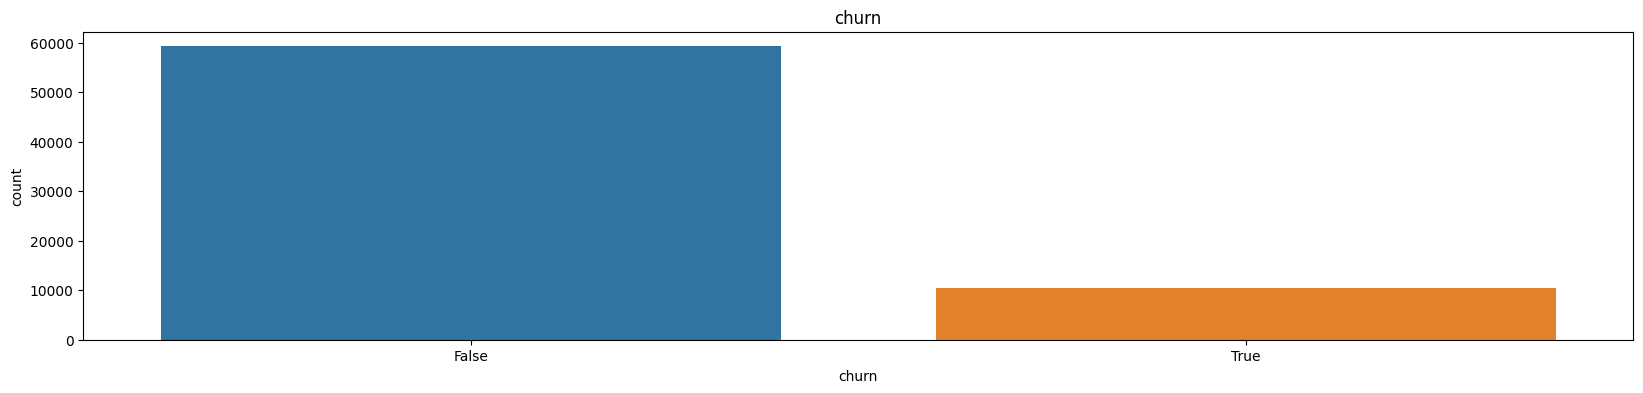

In [ ]:
cols = ['churn']
numerical = cols

plt.figure(figsize=(20,4))

for i, col in enumerate(numerical):
    ax = plt.subplot(1, len(numerical), i+1)
    sns.countplot(x=str(col), data=unique_rows)
    ax.set_title(f"{col}")

We obtain that 10.544 clients are classified as churners, while the remaining entries are not churners.\
So, we have the column `churn` that contains a boolean value, were `True` means churner and `False` means not churner.

#### **2. Preprocessing**

Now we have to **train a model** to predict if unseen customers are possible churners.\
To do so, we need more data. For this reason, we use the `merge` function to append other columns to the table we just create.

***Merging***

In [ ]:
merged_df = pd.merge(unique_rows, customer, on='customer_id', how='inner')
rfm_df_merge = pd.merge(merged_df, rfm_df, on='customer_id', how='inner')
active_customer = pd.merge(rfm_df_merge, customer_account, on='customer_id', how='inner')
active_customer = active_customer.drop('date_month', axis=1)

In [ ]:
active_customer

,customer_id,repurchase_time,churn,address_id,birthdate,gender,email_provider,flag_phone_provided,flag_privacy,age,...,FScore,M_rank_norm,MScore,rf,rfm,account_id,favorite_store,loyalty_type,loyatlty_status,activation_date
0,23,23.116206,True,21,1978-08-14,F,gmail.com,1.0,True,44,...,2,95.451396,2,3,5,512658,49,standard,1,2022-09-08
1,32,15.008194,False,31,1988-10-31,M,hotmail.it,1.0,True,34,...,2,68.635601,2,4,6,849471,49,business premium,1,2023-03-15
2,48,28.894959,True,46,1954-09-23,M,alice.it,1.0,True,68,...,2,98.304529,2,4,6,456894,49,premium,1,2022-08-08
3,50,32.046678,False,48,1979-09-02,F,gmail.com,1.0,True,43,...,0,34.236673,0,1,1,668686,49,premium,1,2022-11-23
4,76,295.111030,False,73,1985-04-08,M,libero.it,1.0,True,38,...,0,25.874170,0,0,0,222056,9,standard,1,2022-04-12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42325,928567,2.054282,False,896882,1965-10-20,F,ymail.com,1.0,True,57,...,2,68.635601,2,4,6,920518,17,standard,1,2023-04-27
42326,928707,3.101181,False,897022,1983-12-06,F,gmail.com,1.0,True,39,...,1,61.800846,1,2,3,920660,27,standard,1,2023-04-27
42327,928777,2.862118,False,897092,1979-03-25,F,hotmail.it,1.0,True,44,...,1,41.508058,1,2,3,920746,21,standard,1,2023-04-27
42328,929438,1.356667,False,897751,1978-07-03,M,alice.it,1.0,True,45,...,1,41.508058,1,2,3,925338,30,standard,1,2023-04-29


In [ ]:
active_customer["churn"].value_counts()

False    33859
True      8471
Name: churn, dtype: int64

As we can see, the dataset is imbalnced. This issue is addressed later with the Oversampling technique.

In [ ]:
active_customer.head()

,customer_id,repurchase_time,churn,address_id,birthdate,gender,email_provider,flag_phone_provided,flag_privacy,age,...,FScore,M_rank_norm,MScore,rf,rfm,account_id,favorite_store,loyalty_type,loyatlty_status,activation_date
0,23,23.116206,True,21,1978-08-14,F,gmail.com,1.0,True,44,...,2,95.451396,2,3,5,512658,49,standard,1,2022-09-08
1,32,15.008194,False,31,1988-10-31,M,hotmail.it,1.0,True,34,...,2,68.635601,2,4,6,849471,49,business premium,1,2023-03-15
2,48,28.894959,True,46,1954-09-23,M,alice.it,1.0,True,68,...,2,98.304529,2,4,6,456894,49,premium,1,2022-08-08
3,50,32.046678,False,48,1979-09-02,F,gmail.com,1.0,True,43,...,0,34.236673,0,1,1,668686,49,premium,1,2022-11-23
4,76,295.111030,False,73,1985-04-08,M,libero.it,1.0,True,38,...,0,25.874170,0,0,0,222056,9,standard,1,2022-04-12


***Remove columns***

Below we remove the columns that we consider **not relevant** for our task, or that contain too many missing vaues.

In [ ]:
target_var = ['churn']
cols_to_remove = ['customer_id', 'repurchase_time',"account_id","R_rank_norm",'RScore','F_rank_norm','FScore','M_rank_norm','MScore','rf','rfm','address_id','birthdate','email_provider','flag_phone_provided','flag_privacy']

In [ ]:
active_customer.drop(cols_to_remove, axis=1, inplace=True)

***Values replacing***

In order to give our data as input to the models, we need to **apply the data** some conversion, in order to have only numerical values. The funcion below acoomplish this goal, by substitute categorical values with numerical ones.\
The following columns were modifed: `gender`, `churn`, `loyalty_type`, `activation_date`.

In [ ]:
def encode(gender):
    res = 0
    if gender == 'M':
        res = 1
    return res

# Apply the function to the 'activation_date' column
active_customer['gender'] = active_customer['gender'].apply(encode)

In [ ]:
def encodechurn(churn):
    res = 0
    if churn == True:
        res = 1
    return res

# Apply the function to the 'activation_date' column
active_customer['churn'] = active_customer['churn'].apply(encodechurn)

In [ ]:
def encode_loyalty(l):
    res = 0
    if l == 'business standard':
        res = 1
    if l == 'premium':
        res = 2
    if l == 'business premium':
        res = 3
    return res

# Apply the function to the 'activation_date' column
active_customer['loyalty_type'] = active_customer['loyalty_type'].apply(encode_loyalty)

In [ ]:
def calculate_days(date_str):
    activation_date = datetime.strptime(date_str, '%Y-%m-%d')
    current_date = datetime.now()
    number_of_days = (current_date - activation_date).days
    return number_of_days

# Apply the function to the 'activation_date' column
active_customer['activation_date'] = active_customer['activation_date'].apply(calculate_days)

In [ ]:
active_customer.head()

,churn,gender,age,Recency,Frequency,Monetary,favorite_store,loyalty_type,loyatlty_status,activation_date
0,1,0,44,69,36,481.64,49,0,1,308
1,0,1,34,28,11,58.85,49,3,1,120
2,1,1,68,0,52,1465.17,49,2,1,339
3,0,0,43,70,4,26.04,49,2,1,232
4,0,1,38,53,3,14.60,9,0,1,457


***Oversampling***

As noted before, **the dataset is unbalanced**. This means that the target classes do not contain the same number of entries. To solve this issue, we apply the `SMOTE` function.

In [ ]:
Xsmote = active_customer.drop('churn', axis=1)  # Features (input variables)
ysmote = active_customer['churn']  # Target variable

# Apply SMOTE to balance the class distribution
smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(Xsmote, ysmote)

# Create a new DataFrame with the balanced data
balanced_active_customer = pd.concat([X_resampled, y_resampled], axis=1)

In [ ]:
y = balanced_active_customer[target_var].values

In [ ]:
balanced_active_customer['churn'].value_counts()

1    33859
0    33859
Name: churn, dtype: int64

In [ ]:
# numerical columns
num_feats = ['age','Recency','Frequency', 'Monetary','favorite_store','activation_date','gender','loyalty_type','loyatlty_status','churn']
# categorical columns
cat_feats = []

***Correlation***

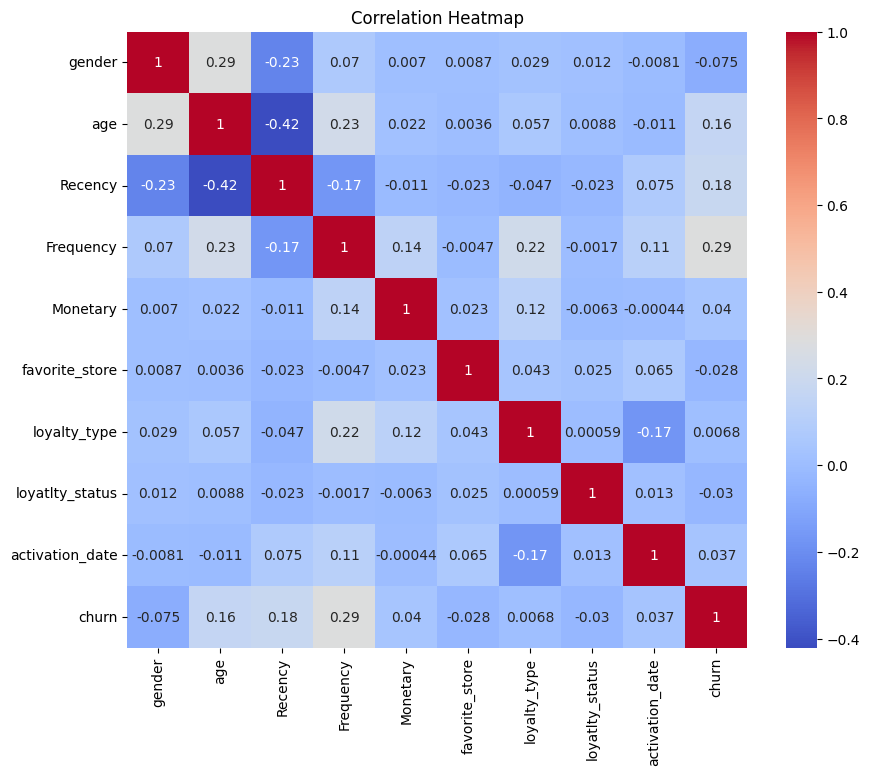

In [ ]:
correlation_matrix = balanced_active_customer.corr()
correlation_matrix = correlation_matrix

# Plot the correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

The correlation matrix usually provides useful insights about how the variables influence the target valriables. In this case, we can see that there are no strong relatioinships between `churn` and the other variables beside `Recency` and `Frequency`.

***Train, test and validation split +  strandardization***

In [ ]:
# Keeping aside a test/holdout set
dc_train_val, dc_test, y_train_val, y_test = train_test_split(balanced_active_customer, y.ravel(), test_size = 0.1, random_state = 42)

# Splitting into train and validation set
dc_train, dc_val, y_train, y_val = train_test_split(dc_train_val, y_train_val, test_size = 0.12, random_state = 42)
dc_train.shape, dc_val.shape, dc_test.shape, y_train.shape, y_val.shape, y_test.shape
np.mean(y_train), np.mean(y_val), np.mean(y_test)

(0.5000186455847255, 0.5028712059064807, 0.496751329001772)

In [ ]:
sc = StandardScaler()
cont_vars = ['age','Recency','Frequency', 'Monetary','favorite_store','activation_date']
cat_vars = ['gender','loyalty_type','loyatlty_status']
# Scaling only continuous columns
cols_to_scale = cont_vars
sc_X_train = sc.fit_transform(dc_train[cols_to_scale])
# Converting from array to dataframe and naming the respective features/columns
sc_X_train = pd.DataFrame(data=sc_X_train, columns=cols_to_scale)
sc_X_train.shape
sc_X_train.head()

,age,Recency,Frequency,Monetary,favorite_store,activation_date
0,-0.688692,-0.800558,1.762363,0.028444,-0.767956,0.218300
1,-0.776303,1.596499,-0.773191,-0.143214,1.517732,-0.779158
2,-0.513470,1.819481,0.160960,-0.111173,0.173210,0.834616
3,-0.601081,-0.521830,-0.105940,-0.083723,0.845471,-0.024982
4,2.728139,-0.939922,-0.439566,-0.121110,-1.507444,-1.290052


In [ ]:
# Scaling validation and test sets by transforming the mapping obtained through the training set
sc_X_val = sc.transform(dc_val[cols_to_scale])
sc_X_test = sc.transform(dc_test[cols_to_scale])
# Converting val and test arrays to dataframes for re-usability
sc_X_val = pd.DataFrame(data=sc_X_val, columns=cols_to_scale)
sc_X_test = pd.DataFrame(data=sc_X_test, columns=cols_to_scale)

In [ ]:
y = dc_train['churn'].values
X = dc_train[cont_vars]
X.columns = cont_vars
X.columns

Index(['age', 'Recency', 'Frequency', 'Monetary', 'favorite_store',
       'activation_date'],
      dtype='object')

**Models**


---
We tried different models to chech which one had better performances on the task.


#### **1. Logistic regression**

In [ ]:
rfe = RFE(estimator=LogisticRegression(), n_features_to_select=10)
rfe = rfe.fit(X.values, y)
# mask of selected features
print(rfe.support_)
# The feature ranking, such that ranking_[i] corresponds to the ranking position of the i-th feature
print(rfe.ranking_)

[ True  True  True  True  True  True]
[1 1 1 1 1 1]


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
mask = rfe.support_.tolist()
selected_feats = [b for a,b in zip(mask, X.columns) if a]
selected_feats

['age',
 'Recency',
 'Frequency',
 'Monetary',
 'favorite_store',
 'activation_date']

In [ ]:
rfe_dt = RFE(estimator=DecisionTreeClassifier(max_depth = 4, criterion = 'entropy'), n_features_to_select=10)
rfe_dt = rfe_dt.fit(X.values, y)

In [ ]:
mask = rfe_dt.support_.tolist()
selected_feats_dt = [b for a,b in zip(mask, X.columns) if a]
selected_feats_dt

['age',
 'Recency',
 'Frequency',
 'Monetary',
 'favorite_store',
 'activation_date']

In [ ]:
selected_cat_vars = [x for x in selected_feats if x in cat_vars]
selected_cont_vars = [x for x in selected_feats if x in cont_vars]
# Using categorical features and scaled numerical features
X_train = np.concatenate((dc_train[selected_cat_vars].values, sc_X_train[selected_cont_vars].values), axis=1)
X_val = np.concatenate((dc_val[selected_cat_vars].values, sc_X_val[selected_cont_vars].values), axis=1)
X_test = np.concatenate((dc_test[selected_cat_vars].values, sc_X_test[selected_cont_vars].values), axis=1)
# print the shapes
X_train.shape, X_val.shape, X_test.shape

((53632, 6), (7314, 6), (6772, 6))

In [ ]:
# Obtaining class weights based on the class samples imbalance ratio
_, num_samples = np.unique(y_train, return_counts=True)
weights = np.max(num_samples)/num_samples
# Define weight dictionnary
weights_dict = dict()
class_labels = [0,1]
# Weights associated with classes
for a,b in zip(class_labels,weights):
    weights_dict[a] = b

weights_dict

{0: 1.0000745851202686, 1: 1.0}

In [ ]:
# Defining model
lr = LogisticRegression(C=1.0, penalty='l2', class_weight=weights_dict, n_jobs=-1)
# train
lr.fit(X_train, y_train)
print(f'Confusion Matrix: \n{confusion_matrix(y_val, lr.predict(X_val))}')
print(f'Area Under Curve: {roc_auc_score(y_val, lr.predict(X_val))}')
print(f'Recall score: {recall_score(y_val,lr.predict(X_val))}')
print(f'Classification report: \n{classification_report(y_val,lr.predict(X_val))}')

Confusion Matrix: 
[[2539 1097]
 [1143 2535]]
Area Under Curve: 0.6937640542194513
Recall score: 0.6892332789559543
Classification report: 
              precision    recall  f1-score   support

           0       0.69      0.70      0.69      3636
           1       0.70      0.69      0.69      3678

    accuracy                           0.69      7314
   macro avg       0.69      0.69      0.69      7314
weighted avg       0.69      0.69      0.69      7314



#### **2. SVM**

In [ ]:
svm = SVC(C=1.0, kernel="linear", class_weight=weights_dict)
svm.fit(X_train, y_train)

SVC(class_weight={0: 1.0000745851202686, 1: 1.0}, kernel='linear')

In [ ]:
print(f'Confusion Matrix: {confusion_matrix(y_val, lr.predict(X_val))}')
print(f'Area Under Curve: {roc_auc_score(y_val, lr.predict(X_val))}')
print(f'Recall score: {recall_score(y_val,lr.predict(X_val))}')
print(f'Classification report: \n{classification_report(y_val,lr.predict(X_val))}')

Confusion Matrix: [[2539 1097]
 [1143 2535]]
Area Under Curve: 0.6937640542194513
Recall score: 0.6892332789559543
Classification report: 
              precision    recall  f1-score   support

           0       0.69      0.70      0.69      3636
           1       0.70      0.69      0.69      3678

    accuracy                           0.69      7314
   macro avg       0.69      0.69      0.69      7314
weighted avg       0.69      0.69      0.69      7314



#### **3. Decision Tree Classifier**

In [ ]:
selected_feats_dt

['age',
 'Recency',
 'Frequency',
 'Monetary',
 'favorite_store',
 'activation_date']

In [ ]:
# Re-defining X_train and X_val to consider original unscaled continuous features. y_train and y_val remain unaffected
X_train = dc_train[selected_feats_dt].values
X_val = dc_val[selected_feats_dt].values
# Decision tree classiier model
clf = DecisionTreeClassifier(criterion='log_loss', class_weight=weights_dict, max_depth=10, max_features=None
                            , min_samples_split=30, min_samples_leaf=20)
# Fit the model
clf.fit(X_train, y_train)
# Checking the importance of different features of the model
pd.DataFrame({'features': selected_feats,
              'importance': clf.feature_importances_
             }).sort_values(by='importance', ascending=False)

,features,importance
5,activation_date,0.476798
2,Frequency,0.218160
1,Recency,0.175788
0,age,0.073824
3,Monetary,0.037158
4,favorite_store,0.018272


In [ ]:
# Validation metrics
print(f'Confusion Matrix: {confusion_matrix(y_val, clf.predict(X_val))}')
print(f'Area Under Curve: {roc_auc_score(y_val, clf.predict(X_val))}')
print(f'Recall score: {recall_score(y_val,clf.predict(X_val))}')
print(f'Classification report: \n{classification_report(y_val,clf.predict(X_val))}')

Confusion Matrix: [[2603 1033]
 [ 535 3143]]
Area Under Curve: 0.7852185504031644
Recall score: 0.8545405111473627
Classification report: 
              precision    recall  f1-score   support

           0       0.83      0.72      0.77      3636
           1       0.75      0.85      0.80      3678

    accuracy                           0.79      7314
   macro avg       0.79      0.79      0.78      7314
weighted avg       0.79      0.79      0.78      7314



The best model is the **Decision Tree Classifier** so we will use it for the predictions.

### **3. Testing and predictions**

In [ ]:
dc_test.head()

,gender,age,Recency,Frequency,Monetary,favorite_store,loyalty_type,loyatlty_status,activation_date,churn
36485,1,68,60,26,314.750000,42,2,1,179,0
21051,1,60,49,2,8.370000,15,0,1,365,0
1696,1,42,100,5,24.180000,42,1,1,521,0
9019,1,69,23,7,22.740000,39,0,1,518,0
46329,1,40,73,24,1652.010442,21,2,1,258,1


In [ ]:
X_test = dc_test.drop(columns=['churn'], axis=1)
X_test = X_test[selected_feats_dt]
# Predict target probabilities
test_probs = clf.predict_proba(X_test)[:, 1]  # Get the probability of the positive class

# Predict target values on test data using probability threshold
test_preds = np.where(test_probs > 0.50, 1, 0)  # Flexibility to tweak the probability threshold

roc_auc_score(y_test, test_probs)
recall_score(y_test, test_preds)
confusion_matrix(y_test, test_preds)
print(classification_report(y_test, test_preds))

              precision    recall  f1-score   support

           0       0.83      0.71      0.76      3408
           1       0.74      0.86      0.80      3364

    accuracy                           0.78      6772
   macro avg       0.79      0.78      0.78      6772
weighted avg       0.79      0.78      0.78      6772



/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


In [ ]:
test = dc_test.copy()
test['predictions'] = test_preds
test['pred_probabilities'] = test_probs
test.sample(5)

,gender,age,Recency,Frequency,Monetary,favorite_store,loyalty_type,loyatlty_status,activation_date,churn,predictions,pred_probabilities
64170,1,48,24,20,151.837560,27,0,1,246,1,1,0.791654
47735,0,58,51,29,725.656422,30,2,1,214,1,1,0.942929
1165,0,60,44,4,137.240000,11,0,1,532,0,0,0.267843
43825,0,50,25,7,29.511733,38,0,1,231,1,1,0.683317
15170,1,69,24,7,62.370000,45,0,1,444,0,0,0.427826


In [ ]:
test[test['predictions']==1]

,gender,age,Recency,Frequency,Monetary,favorite_store,loyalty_type,loyatlty_status,activation_date,churn,predictions,pred_probabilities
1696,1,42,100,5,24.180000,42,1,1,521,0,1,0.528313
46329,1,40,73,24,1652.010442,21,2,1,258,1,1,0.924726
29597,1,66,26,39,347.490000,13,1,1,254,1,1,0.942929
58883,1,64,36,28,583.025420,38,2,1,294,1,1,0.918776
42807,0,40,92,11,131.430609,2,0,1,384,1,1,0.545927
...,...,...,...,...,...,...,...,...,...,...,...,...
12547,1,64,28,14,55.590000,27,0,1,478,0,1,0.598565
52997,1,62,3,16,160.952522,1,0,1,204,1,1,0.887259
26422,1,63,39,8,71.830000,44,0,1,288,1,1,0.531347
61055,1,41,104,3,10.266443,9,1,1,270,1,1,0.528313


**Marketing strategies**


---

In general, we are interested to retain customers that are already clients, so we could implement some strategies that has to goal to keep the customer satisfied with our products/services.\
In this scenario, we could enforce the **following strategies**:
1. send clients regular discounts and coupons;
2. engage more with customers and ask for feedback often;
3. if churn happens, we could analyze ehy it happened and eventually offer the client some benefits in order to retain him, such as discounts, a better subscription plan (`loyalty_plan`) at a more convenient price.

Given the churn prediction for high-value customers, it is crucial to implement business strategies that focus on reducing customer churn and increasing retention. Here are revised strategies:

**Proactive Retention Campaigns**: Implement targeted retention campaigns specifically designed for high-value customers who are at risk of churning. Utilize the RFM analysis and churn prediction models to identify customers with declining purchase frequency or who haven't made a recent purchase. Offer personalized incentives, such as exclusive discounts, loyalty rewards, or freebies, to encourage them to continue their engagement with your supermarket.

**Enhanced Customer Support**: Prioritize providing exceptional customer support to high-value customers. Address any issues or concerns promptly and effectively, ensuring their satisfaction and loyalty. Train your support staff to understand the needs and preferences of these customers, providing personalized assistance and resolving any problems they may encounter.

**Tailored Re-engagement Campaigns**: Develop customized re-engagement campaigns aimed at customers who have already churned or shown signs of disengagement. Utilize personalized communication channels to reach out to these customers, offering them special incentives to return to your supermarket. Highlight new offerings, exclusive promotions, or improvements that may be of interest to them.

**Value-added Services**: Introduce additional value-added services for high-value customers to enhance their shopping experience and increase their loyalty. This could include personalized shopping recommendations, curated product bundles, convenient delivery options, or access to exclusive services like personal shopping assistance or concierge services.

**Continuous Feedback Loop**: Establish a feedback loop with high-value customers to understand their evolving needs and preferences. Regularly solicit their feedback through surveys, focus groups, or customer feedback platforms. Analyze the feedback received and take necessary actions to address any identified pain points or areas for improvement.

**Relationship-building Initiatives**: Foster a sense of community and strengthen relationships with high-value customers. Organize exclusive events, networking opportunities, or VIP gatherings where they can connect with like-minded individuals and share experiences. By building a strong bond between customers and your supermarket, you increase their loyalty and reduce the likelihood of churn.

Remember to continuously monitor the effectiveness of these strategies through churn rate analysis, customer feedback, and retention metrics. Adjust and refine your approaches based on the insights gathered to ensure optimal customer retention and long-term success.

However, based on the potential impact and scalability, the Proactive Retention Campaigns strategy may be the most effective option. It allows for timely intervention, leverages personalized incentives, and demonstrates a proactive commitment to customer retention. While it requires accurate churn prediction and additional resources, it has the potential to yield significant returns in terms of customer loyalty and reduced churn.

# **6. MBA: Market basket analysis**

#### **1. Data manipulation**
For this task we only need the orders table.

In [ ]:
orders = pd.read_csv('tbl_orders.csv')

Here I change the `purchase_datetime` type so that I can make comparisons on the dates.



In [ ]:
orders = pd.read_csv('tbl_orders.csv')
orders['purchase_datetime'] = pd.to_datetime(orders['purchase_datetime'])

In [ ]:
min(orders['purchase_datetime'])

Timestamp('2022-05-01 07:19:05')

In [ ]:
max(orders['purchase_datetime'])

Timestamp('2023-04-30 21:11:41')

In [ ]:
orders.head(3)

,order_id,customer_id,store_id,product_id,direction,gross_price,price_reduction,purchase_datetime
0,8fe4346b53d0c781b275a614175804de,23,49,35551922,1,125.40,0.0,2022-10-04 18:28:51
1,8fe4346b53d0c781b275a614175804de,23,49,30344384,1,8.30,0.0,2022-10-04 18:28:51
2,8fe4346b53d0c781b275a614175804de,23,49,33794292,1,1.99,0.0,2022-10-04 18:28:51


In [ ]:
len(orders['order_id'].unique())

371804

The orders span on a period that goes from `2022-05-01` to `2023-04-30`, and there were 371.804 unique orders.

We will analyse only the orders made in 2023, which represent half of the entries from the `orders` table. This choice is motivated by better computing times and relevance.

In [ ]:
orders2023 = orders[(orders['purchase_datetime'] > datetime(2023,1,1))]

In [ ]:
orders2023.head(3)

,order_id,customer_id,store_id,product_id,direction,gross_price,price_reduction,purchase_datetime
34,8b3bbc136572e9ef8e5f8356b4a28038,23,49,34663923,1,13.98,0.0,2023-02-20 11:51:51
35,8b3bbc136572e9ef8e5f8356b4a28038,23,49,35333095,1,1.99,0.0,2023-02-20 11:51:51
36,8b3bbc136572e9ef8e5f8356b4a28038,23,49,36604596,1,6.90,0.0,2023-02-20 11:51:51


In [ ]:
orders[orders['order_id'] == '7cadcf0f1439461650bf87a4c6bf5a18']

,order_id,customer_id,store_id,product_id,direction,gross_price,price_reduction,purchase_datetime
55,7cadcf0f1439461650bf87a4c6bf5a18,32,49,36046360,1,1.78,0.0,2023-04-02 08:46:45
56,7cadcf0f1439461650bf87a4c6bf5a18,32,49,35881790,1,4.76,0.0,2023-04-02 08:46:45
57,7cadcf0f1439461650bf87a4c6bf5a18,32,49,35661570,1,9.95,0.0,2023-04-02 08:46:45
58,7cadcf0f1439461650bf87a4c6bf5a18,32,49,31047366,1,0.83,0.0,2023-04-02 08:46:45
59,7cadcf0f1439461650bf87a4c6bf5a18,32,49,31047450,1,0.49,0.0,2023-04-02 08:46:45


In [ ]:
len(orders2023['order_id'].unique())

127492

In [ ]:
len(orders2023['customer_id'].unique())

54852

In [ ]:
min(orders2023['purchase_datetime'])

Timestamp('2023-01-02 07:10:35')

In [ ]:
max(orders2023['purchase_datetime'])

Timestamp('2023-04-30 21:11:41')

#### **2. Creation of the cross table**
The cross table will contain one row for each order and one column for each product.\
I am not joining on the `products` table, since if a product was not bought, then I cannot get valuable relationship betwwen them.\
The numbers indicate the quantity of each item bought per order.

In [ ]:
orders2023 = orders2023[['order_id', 'product_id']]

In [ ]:
baskets = pd.crosstab(orders2023['order_id'], orders2023['product_id'])

In [ ]:
baskets

product_id,504553,30033521,30044455,30062452,30072014,30097186,30097291,30097340,30099454,30126292,...,82019008,82026198,82026199,82029521,82029522,82040488,82042962,82042965,82042968,82042974
order_id,,,,,,,,,,,,,,,,,,,,,
000031824fe4f468fc8f68c02e421118,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0000f2817342879fac36a6b9f6a55990,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0001231326e40e177b91e3bbe2c85358,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
000137679b1f0f0cb504623899ae46cd,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0001ca820ec51ee98ac6300276db5368,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fffe88e6619ba61a9d0197a3f34ea945,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ffff259f3015d0bf2dce9e603b15633f,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ffff62942775d9efe6960e90fb12bab2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


The quantity for each item acquired is not relevant, so I ca transform them in the range [0,1].

In [ ]:
def encode(item_freq):
    res = 0
    if item_freq > 0:
        res = 1
    return res

baskets = baskets.applymap(encode)

KeyboardInterrupt: ignored

#### **4. A priori algorithm**


**Market basket analysis (MBA)**


---


It is a data mining technique that is used to uncover purchase patterns in any retail setting. MBA is a set of statistical affinity calculations that help business leaders better understand - and ultimately serve - their customers by highlighting purchasing patterns. In simplest terms, MBA looks for what combinations of products most frequently occur together in transactions. These relationships can be used to increase profitability through cross-selling, recommendations, promotions, or even the placement of items on a menu or in a store.

(From https://smartbridge.com/market-basket-analysis-101/)

An itemset is considered as **"frequent"** if it meets a user-specified support threshold. For instance, if the support threshold is set to 0.5 (50%), a frequent itemset is defined as a set of items that occur together in at least 50% of all transactions in the database.\
In this case we set the threshold at 0.002.

In [ ]:
frequent_itemsets = apriori(baskets, min_support = 0.002, use_colnames=True)

**Support**\
The support of item $I$ is defined as the number of transactions containing $I$ divided by the total number of transactions.
$$Support = \frac{num.\,\, of\,\, transactionction\,\, containing\,\, I}{num.\,\, of \,\, total \,\,transactions}$$

In [ ]:
frequent_itemsets

An **association rule** is a statement of the form "if item A is present in a transaction, then item B is also likely to be present". The strength of the association is measured using the confidence of the rule, which is the probability that item B is present given that item A is present.

In [ ]:
rules = association_rules(frequent_itemsets, metric="lift")

**Conficence**\
Confidence is the likelihood that item $Y$ is also bought if item $X$ is bought. It’s calculated as the number of transactions containing $X$ and $Y$ divided by the number of transactions containing $X$.
$$confidence(X → Y) = \frac{num.\,\, of\,\, transactionction\,\, containing\,\, X \,\, and \,\, Y}{num.\,\, of \,\, transactions \,\, containing\,\, X}$$
\
\
*Lift*, *Levarege* and *Conviction* are the eveluation methods for the algorithm.
\
\
**Lift: evaluation method**\
In this case we will consider only this as metric for the evaluation.\
It is calculated as the confidence of the rule itself compared to the support of its consequent.\
Lift values **greater than unity** indicate that the considered rule is more effective in predicting the relationship between different product patterns. Conversely, lift values **equal to unity** indicate that antecedent and consequent are independent.

In [ ]:
rules.sort_values('lift', ascending = False).reset_index(drop = True)

In [ ]:
rules[rules['lift'] > 1]

In this case, all the rules have a lift value grater than one.

**Marketing strategies**


---


In this scenario, we could implement the **following strategies**:
1. we could choose to put items that relate to each other in a closer shelf, so that they can be found more easily bu the customer;
2. we could offer a discount on the consequent if the client buys the antecedent product;
3. we could offer and recommend the client the antecedent at a lower price.

A *practical example* could be the following scenario: when the customer checks out, the cashier gives him a coupon that guarantees him a discount on the consequent item for the next purchase.

# **7. Sentiment analysis**

#### **Initialization**

For sentiment analysis, the dataset **labelled_reviews** is used, which contains reviews and their corresponding sentiment labels, to train and test the model. The actual predictions will then be made on the **customer_reviews dataset**.

The reviews are cleaned by converting everything to lowercase, removing leading and trailing spaces, and removing all non-alphabetic characters. They are then tokenized, stopwords are removed, and stemming is applied.

In [ ]:
customer_reviews_sa=customer_reviews.copy()
customer_reviews_sa["review_text"]= customer_reviews["review_text"].str.lower()
customer_reviews_sa["review_text"] = customer_reviews_sa["review_text"].str.strip()
customer_reviews_sa['review_text'] = customer_reviews_sa['review_text'].apply(lambda x: re.sub(r'[\W_]', ' ', x))
customer_reviews_sa['review_text'] = customer_reviews_sa['review_text'].apply(lambda x: x.replace("br", ""))

#customer_reviews_sa['sentence'] = customer_reviews_sa['review_text'].apply(nltk.sent_tokenize)

# Tokenizzazione
customer_reviews_sa['tokenized'] = customer_reviews_sa['review_text'].apply(word_tokenize)

# Rimozione delle stopwords
stop_words = set(stopwords.words('english'))
customer_reviews_sa['filtered'] = customer_reviews_sa['tokenized'].apply(lambda tokens: [word for word in tokens if word.lower() not in stop_words])

# Stemming
porter = PorterStemmer()
customer_reviews_sa['stemmed'] = customer_reviews_sa['filtered'].apply(lambda tokens: [porter.stem(word) for word in tokens])




Since the classes are highly imbalanced, there is a risk of classification errors due to overfitting on a particular class. In this case, the negative reviews are the class with the fewest occurrences (42350), so undersampling has been performed on the other classes

In [ ]:
random.seed(10)
labelled_reviews=labelled_reviews[:100000]
positive_count = len(labelled_reviews[labelled_reviews['sentiment_label'] == 'positive'])
print("Numero di elementi positivi:", positive_count)
negative_count = len(labelled_reviews[labelled_reviews['sentiment_label'] == 'negative'])
print("Numero di elementi negativi:", negative_count)
neutral_count = len(labelled_reviews[labelled_reviews['sentiment_label'] == 'neutral'])
print("Numero di elementi neutrali:", neutral_count)

positive_reviews=labelled_reviews[labelled_reviews['sentiment_label'] == 'positive']
positive_reviews=positive_reviews.sample(42350)
negative_reviews=labelled_reviews[labelled_reviews['sentiment_label'] == 'negative']
neutral_reviews=labelled_reviews[labelled_reviews['sentiment_label'] == 'neutral']
neutral_reviews=neutral_reviews.sample(42350)

print(len(positive_reviews))
print(len(negative_reviews))
print(len(neutral_reviews))

labelled_reviews_equal=pd.concat([positive_reviews,negative_reviews,neutral_reviews],ignore_index=True)
labelled_reviews_equal=shuffle(labelled_reviews_equal).reset_index()


In [ ]:
labelled_reviews["review_text"]= labelled_reviews["review_text"].str.lower()
labelled_reviews["review_text"] = labelled_reviews["review_text"].str.strip()
labelled_reviews['review_text'] = labelled_reviews['review_text'].apply(lambda x: re.sub(r'[\W_]', ' ', x))
labelled_reviews['review_text'] = labelled_reviews['review_text'].replace("br br", "")
#tokenization
labelled_reviews['tokenized'] = labelled_reviews['review_text'].apply(word_tokenize)

#stopwords
stop_words = set(stopwords.words('english'))
labelled_reviews['filtered'] = labelled_reviews['tokenized'].apply(lambda tokens: [word for word in tokens if word.lower() not in stop_words])

# Stemming
labelled_reviews['stemmed'] = labelled_reviews['filtered'].apply(lambda tokens: [porter.stem(word) for word in tokens])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(labelled_reviews['stemmed'], labelled_reviews['sentiment_label'], test_size=0.2, random_state=42)

The **TF-IDF** (Term Frequency-Inverse Document Frequency) representation is commonly used in text analysis to represent the relevance of a word in a document compared to the entire corpus of documents

In [ ]:
#TfidfVectorizer
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform([' '.join(review) for review in X_train])
X_test_tfidf = vectorizer.transform([' '.join(review) for review in X_test])

**Models**


---


Different models are used to determine which one provides higher accuracy. For each model, a grid search is performed to find the best parameters.

#### **1. Multinomial Naive Bayes**

In [ ]:
nb_clf = MultinomialNB()

param_grid = { 'alpha': [0.5, 1, 1.5], 'fit_prior': [False, True] }

grid_search = GridSearchCV(nb_clf, param_grid, cv=5)
grid_search.fit(X_train_tfidf, y_train)

best_params = grid_search.best_params_
print("Parametri ottimali:", best_params)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_tfidf)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

In [ ]:
nb_clf = MultinomialNB(alpha=0.5, fit_prior=False)
nb_clf.fit(X_train_tfidf, y_train)

In [ ]:
y_pred = nb_clf.predict(X_test_tfidf)

accuracy_nb = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Stampa delle metriche di valutazione
print('Accuracy:', accuracy_nb)
print('Precision:', precision)
print('Recall:', recall)
print('F1-Score:', f1)

#### **2. Multinomial Logistic Regression**

In [ ]:
# log_reg = LogisticRegression()

# param_grid = { 'penalty': ['l2','l1','elasticnet'], 'C': [0.5,1,1.5], 'solver':['saga', 'newton','newton']}

# grid_search = GridSearchCV(log_reg, param_grid, cv=5)
# grid_search.fit(X_train_tfidf, y_train)

# best_params = grid_search.best_params_
# print("Parametri ottimali:", best_params)

# best_model = grid_search.best_estimator_
# y_pred = best_model.predict(X_test_tfidf)
# accuracy = accuracy_score(y_test, y_pred)
# print("Accuracy:", accuracy)

In [ ]:
log_reg = LogisticRegression()
log_reg.fit(X_train_tfidf, y_train)

In [ ]:
y_pred = log_reg.predict(X_test_tfidf)

accuracy_log = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
prob=log_reg.predict_proba(X_test_tfidf)
# Stampa delle metriche di valutazione
print('Accuracy:', accuracy_log)
print('Precision:', precision)
print('Recall:', recall)
print('F1-Score:', f1)

#### **3. Gradient Boosting Classifier**

In [ ]:
 model = GradientBoostingClassifier()

# param_grid = {
#     'n_estimators': [100, 200, 300],
#     'learning_rate': [0.01, 0.1, 1.0],
#     'max_depth': [3, 5, 7]
# }

# grid_search = GridSearchCV(model, param_grid, cv=5)
# grid_search.fit(X_train_tfidf, y_train)

# best_params = grid_search.best_params_
# print("Parametri ottimali:", best_params)

# best_model = grid_search.best_estimator_
# y_pred = best_model.predict(X_test_tfidf)
# accuracy = accuracy_score(y_test, y_pred)
# print("Accuracy:", accuracy)


In [ ]:
 clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,max_depth=5, random_state=0).fit(X_train_tfidf, y_train)

In [ ]:
y_pred_gbt = clf.predict(X_test_tfidf)

accuracy_gbt = accuracy_score(y_test, y_pred_gbt)
precision = precision_score(y_test, y_pred_gbt, average='weighted')
recall = recall_score(y_test, y_pred_gbt, average='weighted')
f1 = f1_score(y_test, y_pred_gbt, average='weighted')

# Stampa delle metriche di valutazione
print('Accuracy:', accuracy_gbt)
print('Precision:', precision)
print('Recall:', recall)
print('F1-Score:', f1)


In [ ]:
model_labels = ['Nb', 'Log', 'GBT']
accuracies = [accuracy_nb, accuracy_log, accuracy_gbt]

# Creazione del grafico a barre
plt.bar(model_labels, accuracies, )


Considering the accuracy of various models, **multinomial logistic regression provides the higher value**.

In [ ]:
review_tfidf = vectorizer.transform([' '.join(review) for review in customer_reviews_sa['stemmed']])

pred_label = log_reg.predict(review_tfidf)
pred_label

By using a pie chart, the predicted results from logistic regression are plotted, with the intention of focusing on the negative reviews.

In [ ]:
pred=pd.DataFrame(columns=['sentiment_label'], data= pred_label)
#plt.pie(pred_label.count_values())
count=pred.groupby(by='sentiment_label').value_counts()
plt.pie(count.values, labels=count.index,  autopct='%1.1f%%',explode=[0.1,0,0], colors=sns.color_palette('Set2'))
plt.show()
##plt.pie(gender_counts, labels=[f'{label} ({count})' for label, count in zip(gender_counts.index, gender_counts)],
 #       colors=['pink','blue'], autopct='%1.1f%%')

In [ ]:
customer_reviews_sa['predicted label']=pred_label
customer_reviews_sa['score']=0
customer_reviews_sa.loc[customer_reviews_sa['predicted label'] == 'positive', 'score'] = 1
customer_reviews_sa.loc[customer_reviews_sa['predicted label'] == 'negative', 'score'] = -1
customer_reviews_sa

In [ ]:
desired_columns = ['customer_id', 'review_text', 'score']

customer_neg = customer_reviews_sa.loc[customer_reviews_sa['score'] == -1,desired_columns].copy()
customer_neg

The idea is to **categorize the main issues identified in the reviews into macro-categories**, which are as follows:

- *shipping*, problems related to the shipping,packaging and boxing

- *food*, issues related to the product offered by the provider

- *money*, related to the high cost of the product

- *customer_service*

In [ ]:
# Assuming you have the review data in a DataFrame called 'reviews' with a column named 'review_text'

# Concatenate all the review texts into a single string
all_reviews = ' '.join(customer_neg['review_text'])

# Create a WordCloud object
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_reviews)

# Plot the WordCloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [ ]:
customer_neg

In [ ]:
customer_neg['review_text']

In [ ]:
shipping_reviews =[]
money_reviews=[]
food_reviews=[]
service_reviews=[]

food_list=['coffee', 'water', 'chip','tea','food','taste','flavor','chocolate']
shipping_list=['amazon','box','packaging','package']



# Iterate over each review
for index, row in customer_neg.iterrows():
  for food in food_list:
    review = row['review_text']
    if  food in review:
        customer_id = row['customer_id']
        food_reviews.append(customer_id)

for index, row in customer_neg.iterrows():
  for shipping in shipping_list:
    review = row['review_text']
    if  shipping in review:
        customer_id = row['customer_id']
        shipping_reviews.append(customer_id)

for index, row in customer_neg.iterrows():
    review = row['review_text']
    if 'customer service' in review:
        customer_id = row['customer_id']
        service_reviews.append(customer_id)
    if 'money' in review:
        customer_id = row['customer_id']
        money_reviews.append(customer_id)

shipping_reviews =list(set(shipping_reviews))
money_reviews=list(set(money_reviews))
food_reviews=list(set(food_reviews))
service_reviews=list(set(service_reviews))

In [ ]:
p={'customer_id':service_reviews}
service_neg=pd.DataFrame(p)

s={'customer_id':shipping_reviews}
shipping_neg=pd.DataFrame(s)

m={'customer_id':money_reviews}
money_neg=pd.DataFrame(m)

f={'customer_id':food_reviews}
food_neg=pd.DataFrame(f)

In [ ]:
print(food_neg)
print(shipping_neg)
print(money_neg)
print(service_neg)

In [ ]:
food_neg['food_neg']=1
shipping_neg['shipping_neg']=1
money_neg['money_neg']=1
service_neg['service_neg']=1

customer_neg = customer_neg.merge(food_neg, on='customer_id', how='left')
customer_neg = customer_neg.merge(shipping_neg, on='customer_id', how='left')
customer_neg = customer_neg.merge(money_neg, on='customer_id', how='left')
customer_neg = customer_neg.merge(service_neg, on='customer_id', how='left')

In [ ]:
customer_neg = customer_neg.fillna(0)
customer_neg

**Marketing strategies**


---


In this scenario, we could implement the **following strategies**, based on the **flag associated** with the columns:

- **food_neg** columns, when customers reach a specific threshold, they become eligible for a special discount on a higher quality product. This allows them to enjoy a reduced price while upgrading their purchase to a superior option.

- **Money_neg** columns, customers are provided with a valuable discount coupon that they can use to avail a 15% off their total purchase. This coupon serves as a monetary benefit, allowing them to save a significant amount on their transaction.

- **shipping_neg** columns, customers will receive the added convenience of free shipping once they surpass a certain spending threshold. This perk encourages them to increase their purchase value, knowing that they will not have to pay for the shipping costs, ultimately enhancing their overall shopping experience.

- **service_neg** columns : Since there are few customers who have complained about the customer service, we could send an email to gather feedback on the negative aspects in order to improve them

**Positive reviews**
- **Loyalty Program**: Offer customers with positive reviews the opportunity to participate in a loyalty program. .

- **Testimonial Campaigns**: Ask customers with positive reviews to provide more detailed testimonials or reviews that can be used to promote the product or service in marketing campaigns. Positive customer testimonials can be a powerful form of advertising, and it's important to collect and share these positive experiences to influence potential customers.

- **Events or Workshops**: Organize exclusive events or workshops for customers with positive reviews. This provides them with the opportunity to firsthand experience new products, receive personalized consultations, or participate in training sessions. These exclusive events can create a sense of belonging and gratitude towards the brand, while also providing a unique experience to loyal customers.

# **8. Extra point 1: Electra-Small**

Since the BERT model is too heavy due to its numerous parameters, it has been chosen to use the **electra_small** model.

It is a smaller variant of the Electra model, which means it has fewer parameters and is more computationally efficient compared to its larger counterparts. We use this model to accomplish the sentiment analysis task.






In [ ]:
model_name='https://tfhub.dev/google/electra_small/2'
preproces_name='https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'

- **text_input**: This layer defines the input for the model, which represents the text data to be processed. It takes in a string input of any shape.

- **preprocessing_layer**: This layer utilizes the KerasLayer from TensorFlow Hub to preprocess the text input.

- **encoder_inputs**: This layer takes the preprocessed inputs from the preprocessing_layer and passes them as inputs to theencoder layer. It prepares the text inputs for encoding.

- **encoder**: This layer utilizes the KerasLayer from TensorFlow Hub to load and utilize a encoder model. The encoder processes the inputs and generates contextualized representations of the text.

- **outputs**: This layer captures the outputs generated by the encoder layer. It provides access to various outputs from the model, such as the pooled output, which represents the entire input sequence in a fixed-length representation.

- **net**: This layer applies a dropout regularization technique to the pooled output. Dropout randomly sets a fraction of input units to 0 during training, which helps prevent overfitting and improves generalization.
Then applies a fully connected dense layer with 3 units (neurons). It performs a linear transformation on the input data, preparing it for classification.
It applies a softmax activation function to the outputs of the previous layer. Softmax converts the output values into a probability distribution, allowing the model to predict the probabilities of each class in a multi-class classification problem.

In [ ]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(preproces_name, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(model_name, trainable=True, name='encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.3)(net)
  net = tf.keras.layers.Dense(3, activation=None, name='classifier')(net)
  net= tf.keras.layers.Softmax()(net)
  return tf.keras.Model(text_input, net)

In [ ]:
classifier_model = build_classifier_model()

The **SparseCategoricalCrossentropy** loss function is a commonly used choice for multi-class classification problems. It calculates the cross-entropy loss between the predicted probabilities and the true labels, where the true labels are provided as integers

The **SparseCategoricalAccuracy**metric is used here, which calculates the accuracy of the model's predictions by comparing them to the true labels

In [ ]:
loss = tf.keras.losses.SparseCategoricalCrossentropy()
metrics = tf.keras.metrics.SparseCategoricalAccuracy()

In [ ]:
positive_reviews=labelled_reviews[labelled_reviews['sentiment_label'] == 'positive']
positive_reviews=positive_reviews.sample(42350)
negative_reviews=labelled_reviews[labelled_reviews['sentiment_label'] == 'negative']
neutral_reviews=labelled_reviews[labelled_reviews['sentiment_label'] == 'neutral']
neutral_reviews=neutral_reviews.sample(42350)
labelled_reviews_equal=pd.concat([positive_reviews,negative_reviews,neutral_reviews],ignore_index=True)
labelled_reviews_equal=shuffle(labelled_reviews_equal).reset_index()


In [ ]:
text_data = labelled_reviews_equal['review_text']
#preprocessed_data = bert_preprocess_model(text_data)


In [ ]:
#sentiment_labels = labelled_reviews['sentiment_label'].map({'negative': tf.convert_to_tensor(np.array([1,0,0])), 'neutral': tf.convert_to_tensor(np.array([0,1,0])), 'positive': tf.convert_to_tensor(np.array([0,0,1]))})
sentiment_labels = labelled_reviews_equal['sentiment_label'].map({'negative': 0, 'neutral': 1, 'positive': 2})
train_data=text_data[:90000]
val_data=text_data[90000:]
train_labels=sentiment_labels[:90000]
val_labels=sentiment_labels[90000:]

#train_data, test_data, train_labels, test_labels = train_test_split(text_data, sentiment_labels, test_size=0.2, random_state=42)


In [ ]:
pred=customer_reviews['review_text']

In [ ]:
classifier_model.summary()

The provided code defines three callbacks:

- **ModelCheckpoint**: This callback is used to save the model during training. In this case, the model is saved to the "finetune.h5" file every time there is an improvement in the evaluation metrics. The parameter save_best_only=True ensures that only the best version of the model is saved.

- **EarlyStopping**: This callback is used to stop training early if no improvement is observed in the evaluation metrics for a specified number of epochs (in the code, patience=5). It monitors the specified evaluation metric (in this case, 'val_loss') and stops if no improvement is seen for the specified number of epochs.

- **ReduceLROnPlateau**: This callback reduces the learning rate when an evaluation metric stops improving. The monitor parameter specifies the evaluation metric to monitor (in this case, 'val_loss'). If no improvement is observed for a specified number of epochs (patience=2), the learning rate is reduced by multiplying it with the specified factor (factor=0.1). The min_lr parameter specifies the minimum allowed value for the learning rate.

In [ ]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint("finetune.h5", verbose=1, save_best_only=True),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=1e-8, verbose=1),
]

In [ ]:
classifier_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=3e-5),
              loss=loss,
              metrics=metrics)



The following code will only be executed if the model is being trained. To avoid a long wait, you can skip it and load the weights onto the model

In [ ]:
history = classifier_model.fit(train_data,train_labels,validation_data=(val_data,val_labels),
                               epochs=20,callbacks=[callbacks])

In [ ]:
classifier_model.load_weights("finetune3.h5")

In [ ]:
predictions = classifier_model.predict(pred)

In [ ]:
def compute_sentiment(prediction):
  sentiment_label = np.argmax(prediction)

  if sentiment_label == 0:
      sentiment = 'negative'
  elif sentiment_label == 1:
      sentiment = 'neutral'
  elif sentiment_label == 2:
      sentiment = 'positive'
  return sentiment

In [ ]:
p=compute_sentiment(predictions[2])
print(pred[2])
print(p)

In [ ]:
sentiments = list(map(lambda prediction: compute_sentiment(prediction), predictions))

In [ ]:
customer_reviews['predicted_label'] = sentiments
customer_reviews.head()

As previously, the strategy will be to determine the categories of negative reviews, in order to intervene specifically.

# **9. Extra point 2: marketing campaign that combine 2 different aspects**

It could be useful to **provide only some clients** more interesting offers. For example, we can offer high-value customer specific offers based on their personal shopping cart.
For this reason, we can integrate RFM and MBA analyses to gain a comprehensive understanding of customer behavior and preferences, develop a customer segmentation strategy based on RFM scores and market basket analysis results to tailor marketing efforts.
We can utilize data-driven insights to optimize pricing strategies, promotional offers, and product assortment.\
\
We are interested in offering **only to diamonds customers a discount on the consequent (found with the MBA technique) of their favourite products**.



In [ ]:
# filter only diamond
diamond = rfm_df[rfm_df['rfm'] == 6]
diamond

In [ ]:
# get their orders
diamond_orders = diamond.merge(orders, on='customer_id', how='left')
diamond_orders

In [ ]:
occurrences = diamond_orders.groupby(['customer_id', 'product_id']).size().reset_index(name='occurrences')

In [ ]:
occurrences['max_occurrences'] = occurrences.groupby('customer_id')['occurrences'].transform('max')

In [ ]:
# keep only the products with max occurence
occurrences = occurrences[occurrences['occurrences'] == occurrences['max_occurrences']].sort_values('occurrences', ascending = False).reset_index(drop = True).drop('max_occurrences', axis = 1)

In [ ]:
occurrences

For each diamond client, we have their **favourite products**, that are the item they bought the most. Now we can integrate the MBA output and then implement a marketing strategy.

From the `rules` table of the MBA, we are interested only on the rows that contain onyl one procuct as antecedent.

In [ ]:
rules['length'] = rules['antecedents'].apply(lambda x: len(x))
rules_ones = rules[ rules['length'] == 1]
rules_ones = rules_ones.drop('length', axis = 1)
rules_ones

In [ ]:
string_values = rules_ones['antecedents'].apply(lambda x: str(next(iter(x))).strip())

In [ ]:
rules_ones['antecedents'] = string_values

In [ ]:
rules_ones

In [ ]:
rules_ones['antecedents'] = rules_ones['antecedents'].apply(lambda x: int(x))

In [ ]:
rules_ones['antecedents'].dtype

Now I can join the RFM and MBA results.

In [ ]:
frm_mba = occurrences.merge(rules_ones, left_on='product_id', right_on='antecedents', how='right')
output = frm_mba[['customer_id','product_id','occurrences','antecedents','consequents']]
output

Integrate RFM and MBA analyses is useful to
* **gain a comprehensive understanding of customer behavior and preferences**;
* **Develop a customer segmentation strategy** based on RFM scores and market basket analysis results to tailor marketing efforts;
* Utilize **data-driven insights** to optimize pricing strategies, promotional offers, and product assortment;
* Continuously **monitor and analyze customer behavior** to adapt and refine strategies over time.

\


**Marketing strategies**


---


In this scenario, we could implement the **following strategy**: for each diamond customer, we provide him a personalized discount on the predicted consequent item based on his favorite product (antecedent). Furthermore, the value of the discount could be customized on the occurrences: this means that the more a client purchased a specfic product, the more the consequent item recommended will be discounted.

In [ ]:
output['occurrences'].describe()

In [ ]:
percentile_75 = output['occurrences'].quantile(0.75)
percentile_50 = output['occurrences'].quantile(0.5)

# Apply discount based on percentile ranges
output['discount'] = pd.np.where(output['occurrences'] > percentile_75, 0.2, pd.np.where(output['occurrences'] > percentile_50, 0.1, 0.05))

In [ ]:
output

In this case, we set a discount of:
* 20% if the occurrences are above the 0.75 quantile of the `occurrences` distribution
* 5% if the occurrences are between the 0.75 and 0.5 quantile
* 1% otherwise.

Discounts will be send via mail and text messages.